<a href="https://colab.research.google.com/github/vzinkovski/umich_siads_capstone/blob/main/capstone_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
%%capture

# install missing libraries
!pip install fredapi
!pip install lightgbm
!pip install skorch
!pip install watermark

In [2]:
%%capture
import os

# manually install technical analysis library
# due to compatibility issues with google colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
os.chdir('ta-lib')
!./configure --prefix=/usr
!make
!make install # wait ~ 30s
os.chdir('../')
!pip install TA-Lib

In [3]:
%%capture

# api libraries
import yfinance as yf
import fredapi as fa

# financial libraries
import talib

# machine learning libraries
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import precision_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import lightgbm as lgb
from lightgbm import LGBMClassifier

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skorch.callbacks import EpochScoring
from skorch import NeuralNetClassifier

# standard libraries
import numpy as np
import pandas as pd
from scipy.stats import zscore

# visualisation libraries
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score
import seaborn as sns

# feature engineering
from sklearn.preprocessing import StandardScaler

# utility
import gc
import pickle
import requests
from tqdm import tqdm
import warnings
from joblib import dump, load

In [4]:
# pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# other display
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
!pip freeze > requirements.txt

# Load data

## Define date range

In [ ]:
# define date range for entire download
start_date = '2000-01-01'
end_date = '2023-12-31'

# define training and validation date ranges
end_train_date = '2017-12-31'
end_valid_date = '2020-12-31'

## Stock data

In [ ]:
# # google drive save locations
# sp500_tickers_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/sp500_tickers.txt'
# sp500_data_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/sp500_data.parquet'

### Wikipedia

In [ ]:
# # get list of sp500 tickers
# sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# sp500_tickers = sp500_tickers.Symbol.tolist()

# # save sp500 tickers to text file in google drive
# with open(sp500_tickers_path, 'w') as f:
#     for symbol in sp500_tickers:
#         f.write(symbol + '\n')

In [ ]:
# load sp500 tickers from text file
sp500_tickers_url = 'https://github.com/vzinkovski/capstone/raw/main/sp500_tickers.txt'
response = requests.get(sp500_tickers_url)

# get ticker list
sp500_tickers = response.text.splitlines()

### Yahoo! Finance

In [ ]:
# # download ohlc price and volume data
# yf_df = yf.download(sp500_tickers, start=start_date, end=end_date)

# # save sp500 data to parquet file in google drive
# yf_df.to_parquet(sp500_data_path, compression='gzip', index=True)

In [ ]:
# load sp500 data from parquet file
sp500_data_url = 'https://github.com/vzinkovski/capstone/raw/main/sp500_data.parquet'
yf_df = pd.read_parquet(sp500_data_url)

# reshape df from wide to long
yf_df = yf_df.stack().reset_index(level=1)

## Macroeconomic data

### Federal Reserve Economic Data

In [ ]:
api_key = "a74d505e6731a2b5b06fdcf6ca20f6f5"
fred = fa.Fred(api_key = api_key)

In [ ]:
#get daily data

#select Fred data code to retrieve
daily = ['DFF', #Fed Fund Effective Rate, from 1954-07-01
         'DGS10', #10 year constant maturity US Treasury, from 1962-01-02
         ]

#create dictionary to rename columns
daily_columns = {'DFF':'FFE_Rate',
                 'DGS10':'10yr_UST'}

daily_df = pd.DataFrame()

for code in daily:
  series = fred.get_series(code)
  series_df = pd.DataFrame(series)
  series_df.columns = [code]
  daily_df = pd.merge(daily_df, series_df, left_index=True, right_index=True, how='outer') #how = outer to keep entire dates

daily_df = daily_df.rename(columns = daily_columns)
daily_df = daily_df.fillna(method='ffill')
daily_df = daily_df.shift(1) #creating 1 day lag to avoid data leakage (closing rate not available until the day closes)
daily_df = daily_df.loc['2000-01-01':'2023-12-31']

daily_df.tail()


,FFE_Rate,10yr_UST
2023-12-27,5.3300,3.8900
2023-12-28,5.3300,3.7900
2023-12-29,5.3300,3.8400
2023-12-30,5.3300,3.8800
2023-12-31,5.3300,3.8800


In [ ]:
def daily_conversion(df, start_date='2000-01-01', end_date='2023-12-31', fill_method = 'ffill'):
  new_dates = pd.date_range(start=start_date, end=end_date, freq='D')

  # Ensure new_dates is unique
  new_dates = pd.unique(new_dates)

  # Ensure df's index has no duplicates
  if df.index.duplicated().any():
    df = df[~df.index.duplicated(keep='first')]

  df_break = df.reindex(df.index.union(new_dates))
  df_break = df_break.fillna(method=fill_method)

  return df_break

In [ ]:
def get_monthly_data(fred_code, rename_dict):
  renamed = rename_dict[fred_code]

  df = fred.get_series_all_releases(fred_code)
  df = df[df['date']>'1999-01-01']
  df = df.drop_duplicates(subset='date', keep='first') #this removes revisions and avoid data leakage

  #break quarterly data to daily by forward fill
  df.set_index('realtime_start',inplace=True)
  df = daily_conversion(df)

  #%change shown only on the release day - to simplify, % change is calculated vs previous value without annualization
  df[f'{renamed}_%'] = df['value'].pct_change() *100

  #date filtered
  df = df.loc['2000-01-01':'2023-12-31']

  df = df[['value',f'{renamed}_%']]
  df = df.rename(columns = {'value':renamed})

  return df

In [ ]:
#get monthly data
#select Fred data code to retrieve
monthly = ['CPILFESL', #CPI for All Urban Consumers: All Items Less Food and Energy in U.S. City Ave., seasonally adjusted, Index 1982-1984=100, Jan 1957 to Apr 2023
         'PAYEMS', #All Employees, Total Nonfarm, seasonally adjusted, Unit #, Jan 1939 to May 2023
         'UNRATE', #Unemployment Rate, Unit %, Jan 1948 to May 2023
         'PCE', #Personal Consumption Expenditures. seasonally adjusted annual rate, unit = $bil, Jan 1959 to Apr 2023
         'INDPRO', #Industrial Production: Total Index, seasonally adjusted, Unite = Index 2017=100, Jan 1919 to Apr 2023
         ]

#create dictionary to rename columns
monthly_columns = {'CPILFESL':'CPI_Core',
                   'PAYEMS':'Nonfarm_Payroll',
                   'UNRATE':'Unemployment_Rate',
                   'PCE':'PCE',
                   'INDPRO':'Ind_Prod',
                   }

#monthly_df = get_fred_data(monthly, monthly_columns, start_date,end_date)

In [ ]:
monthly_df = pd.DataFrame()

for code in monthly:
  mo_data = get_monthly_data(code, monthly_columns)
  monthly_df = pd.merge(monthly_df, mo_data, left_index=True, right_index=True, how='outer') #how = outer to keep entire dates

# Calculating moving averages for columns ending with "%"
cols_to_average = [col for col in monthly_df.columns if col.endswith("%")]
for col in cols_to_average:
    for window in [7, 30, 60, 90]:
        monthly_df[f'{col}_{window}d_ma'] = monthly_df[col].rolling(window=window, min_periods=1).mean()

monthly_df.tail()

,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma
realtime_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-27,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0194,0.0000,-0.0014,-0.0152,-0.0088
2023-12-28,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-29,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-30,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088
2023-12-31,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088


In [ ]:
#get GDP data

gdp = fred.get_series_all_releases('GDP')
gdp = gdp[gdp['date']>='1999-01-01']

#dataset has many release date due to back date revisions. Keeping only first 3 monthly updates for simplification
gdp['date'] = pd.to_datetime(gdp['date'])
gdp['rank'] = gdp.groupby('date').cumcount() + 1
gdp = gdp[gdp['rank'] <= 3]
gdp = gdp.drop(columns=['rank'])
gdp = gdp.drop_duplicates(subset='realtime_start', keep='last') #when 2 releases on same day, keeping latest quarter data only
gdp.set_index('realtime_start',inplace=True)

#break quarterly data to daily by forward fill
new_dates = pd.date_range(start='1999-01-01', end='2023-12-31', freq='D')
gdp_break = gdp.reindex(gdp.index.union(new_dates))
gdp_break = gdp_break.fillna(method='ffill')

#%change shown only on the release day - to simplify, % change is calculated vs previous GDP value without annualization
gdp_break['GDP_%'] = gdp_break['value'].pct_change() *100

# Calculating moving averages for columns ending with "%"
cols_to_average = [col for col in gdp_break.columns if col.endswith("%")]
col_list = ['value','GDP_%']
for col in cols_to_average:
    for window in [7, 30, 60, 90]:
        gdp_break[f'{col}_{window}d_ma'] = gdp_break[col].rolling(window=window, min_periods=1).mean()
        col_list.append(f'{col}_{window}d_ma')

#date filtered
gdp_break = gdp_break.loc['2000-01-01':'2023-12-31']

gdp_break = gdp_break[col_list]
gdp_break = gdp_break.rename(columns = {'value':'GDP'})

gdp_break.tail()

,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
2023-12-27,27610.1280,0.0000,-0.0177,-0.0016,-0.0008,0.0225
2023-12-28,27610.1280,0.0000,0.0000,-0.0016,-0.0008,0.0225
2023-12-29,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-30,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-31,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


In [ ]:
macro_df = pd.concat([daily_df, monthly_df, gdp_break], axis=1)
macro_df.tail()

,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
2023-12-27,5.3300,3.8900,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0194,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,-0.0177,-0.0016,-0.0008,0.0225
2023-12-28,5.3300,3.7900,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,-0.0044,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0016,-0.0008,0.0225
2023-12-29,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-30,5.3300,3.8800,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-31,5.3300,3.8800,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,-0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


In [ ]:
# the unit of each economic data is different
# Adding standardized columns with "_st" suffix for columns without "%"

#cols_to_standardize = [col for col in macro_df.columns if not col.endswith("%") and not col.endswith("ma")]
#scaler = StandardScaler()
#for col in cols_to_standardize:
#    macro_df[f'{col}_st'] = scaler.fit_transform(macro_df[[col]])

#macro_df.tail()

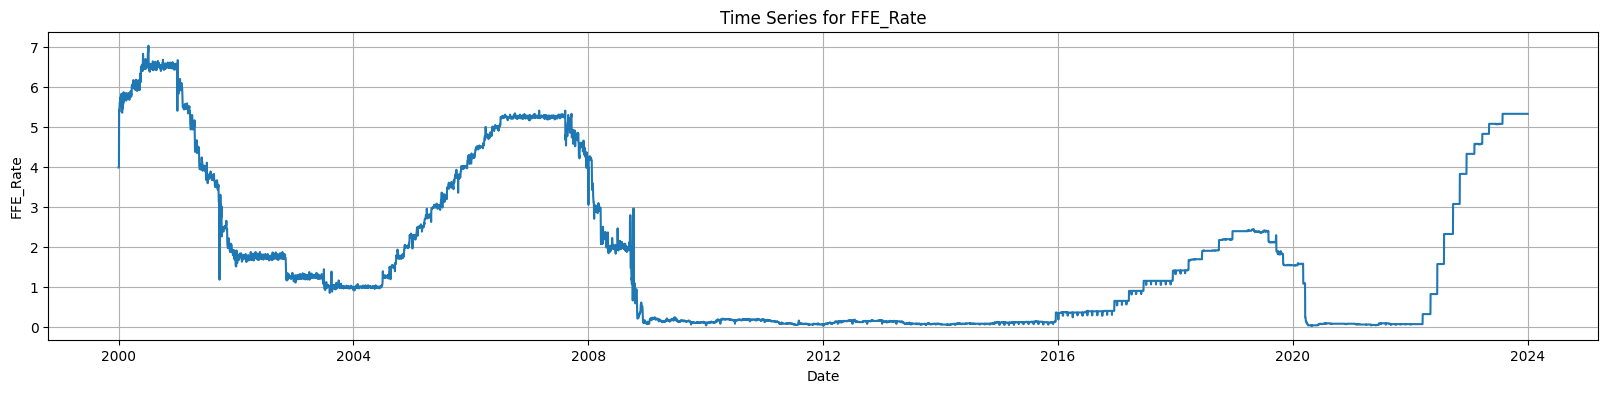

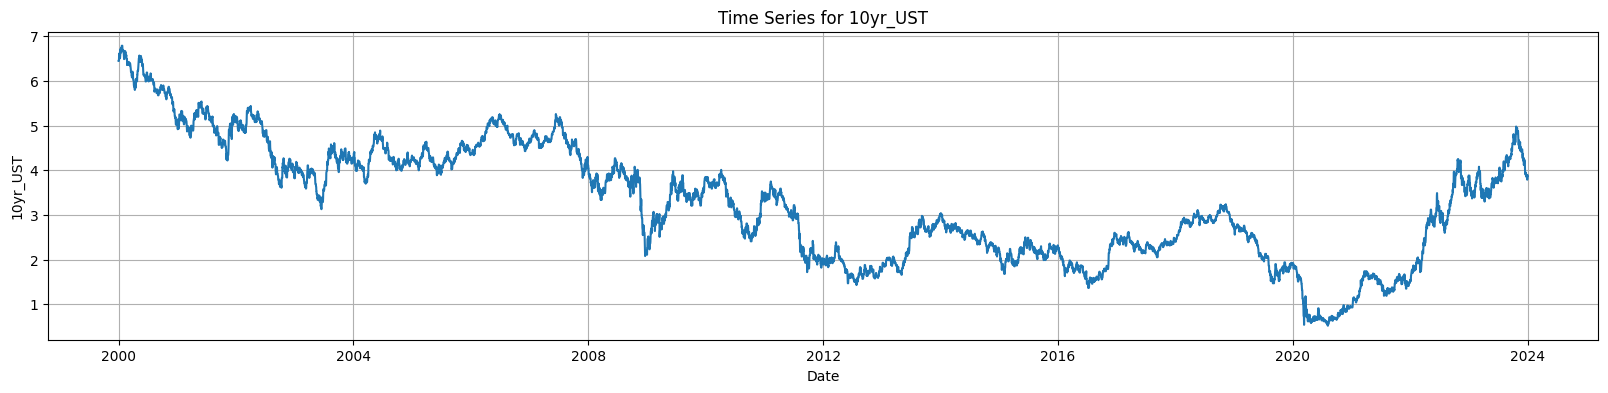

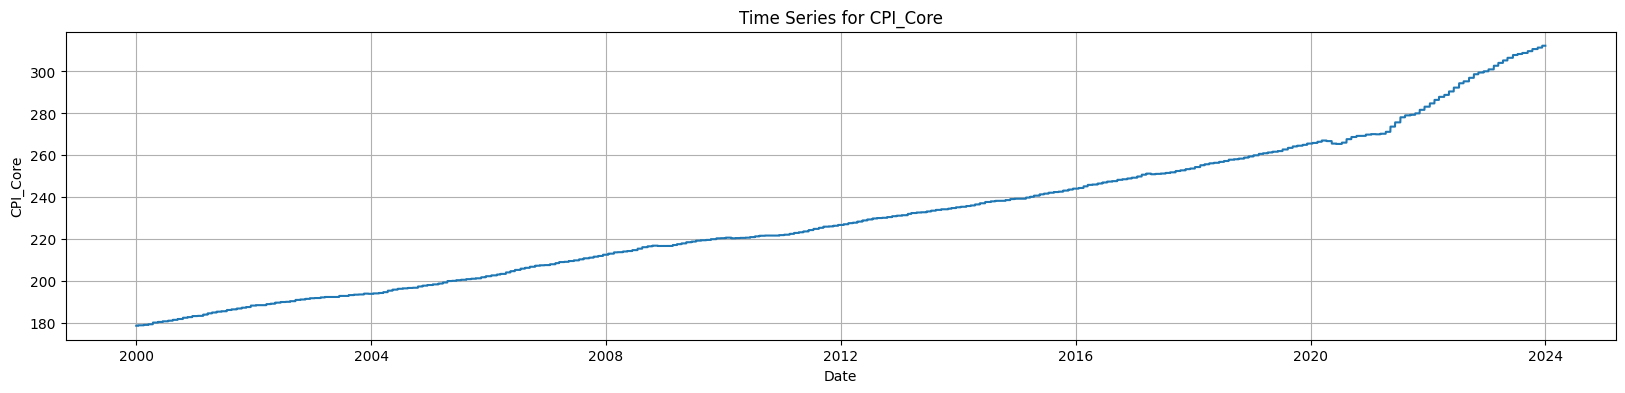

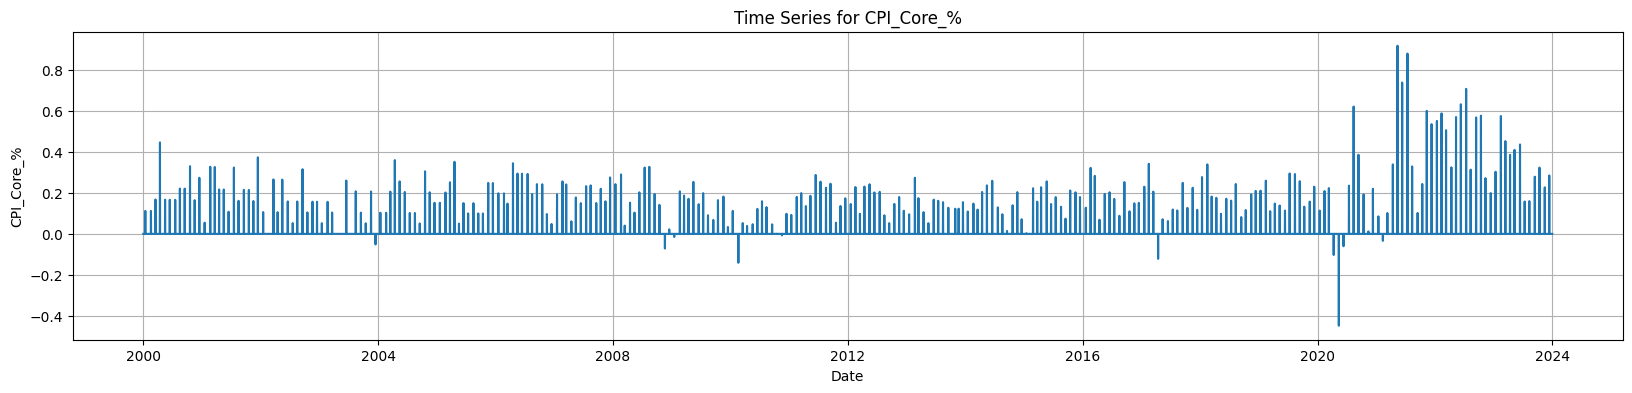

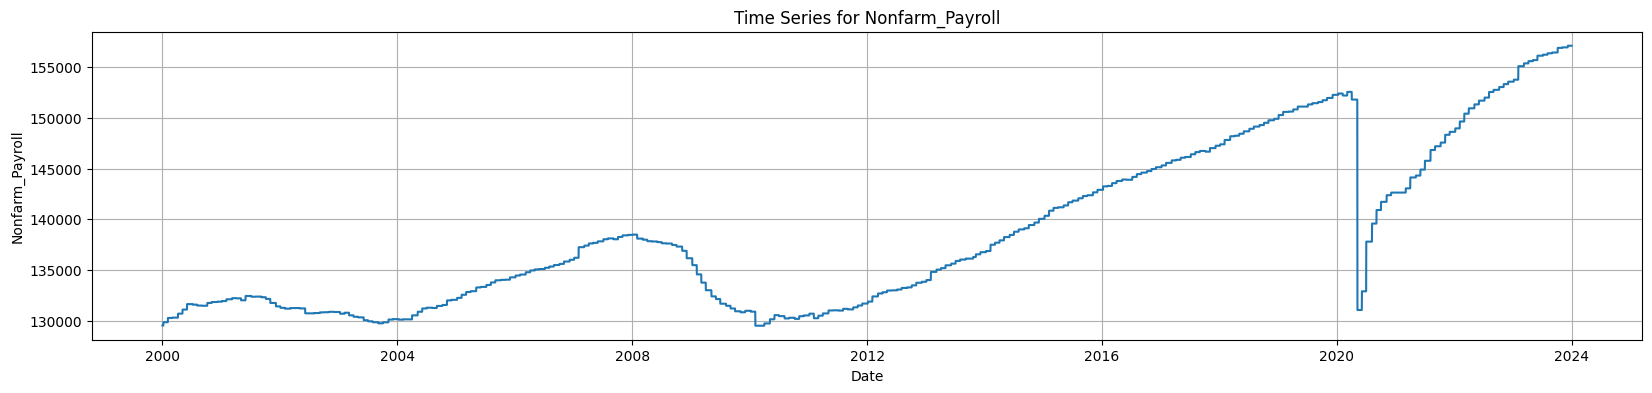

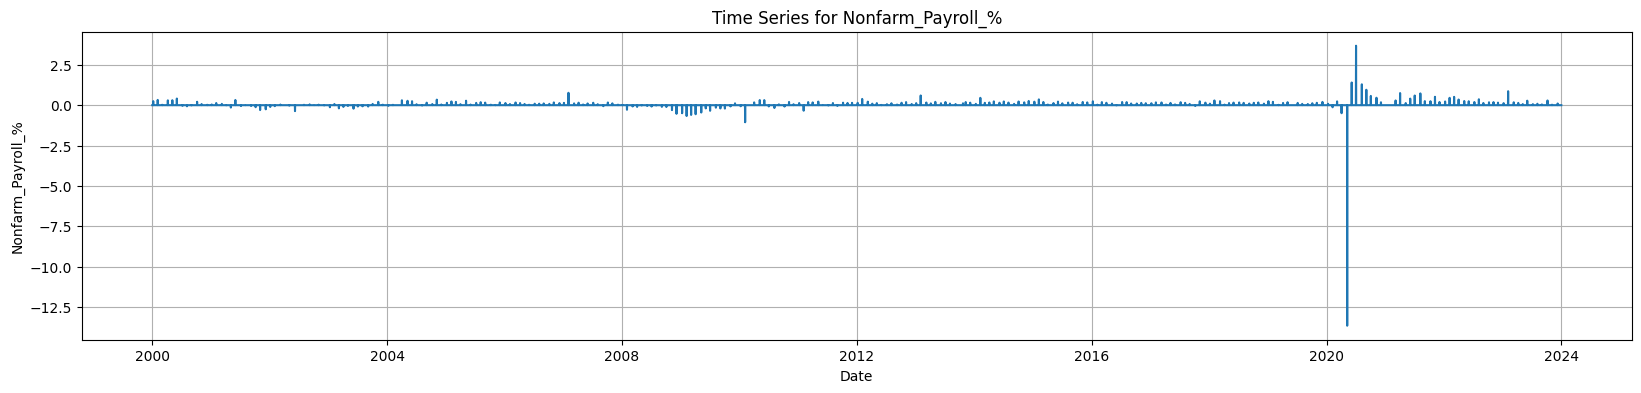

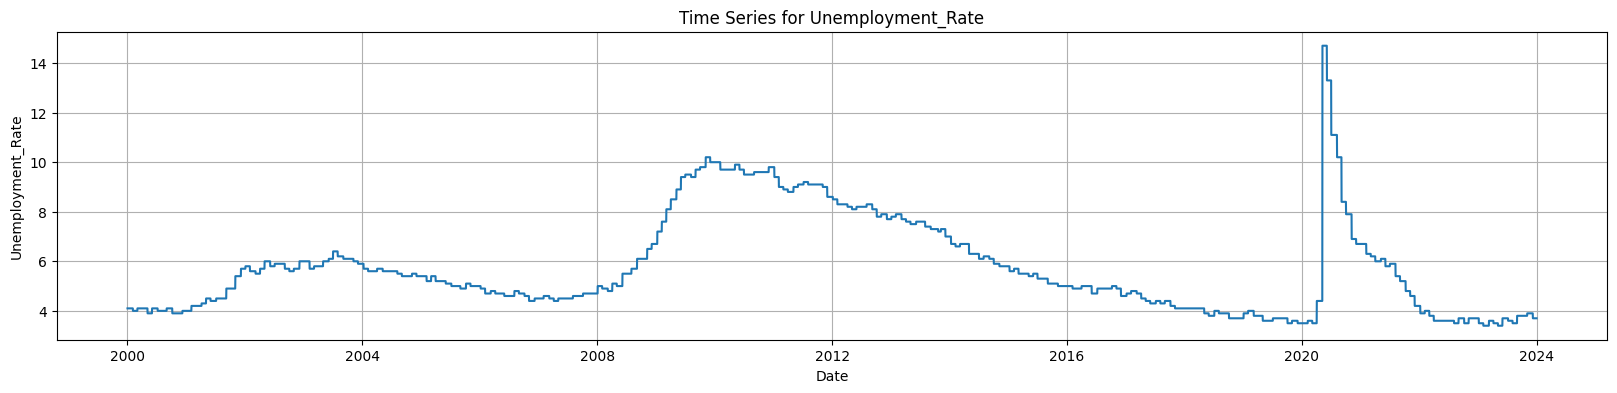

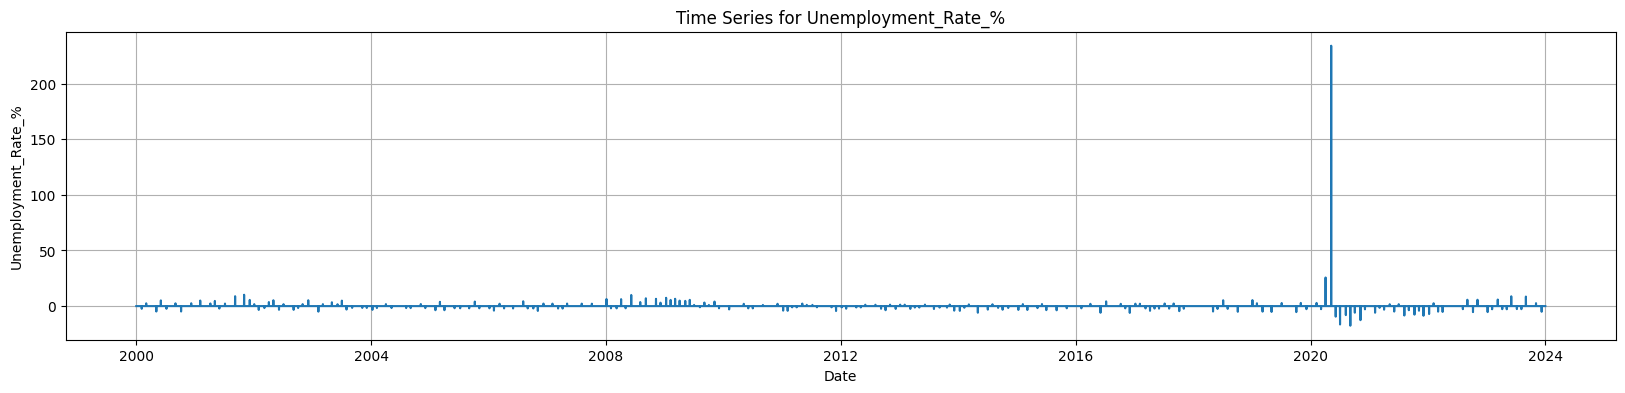

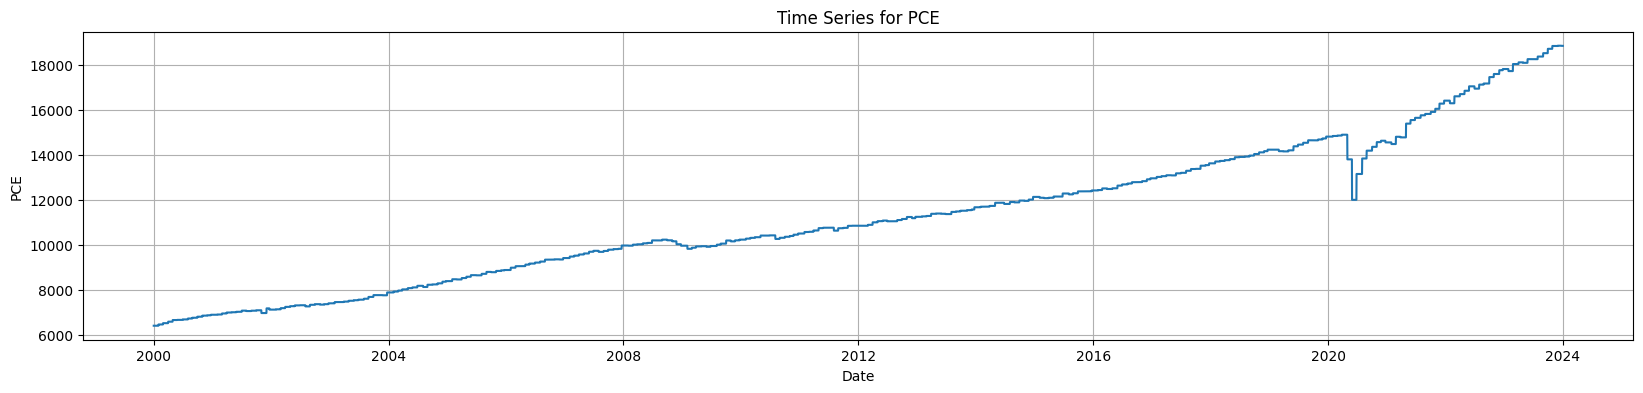

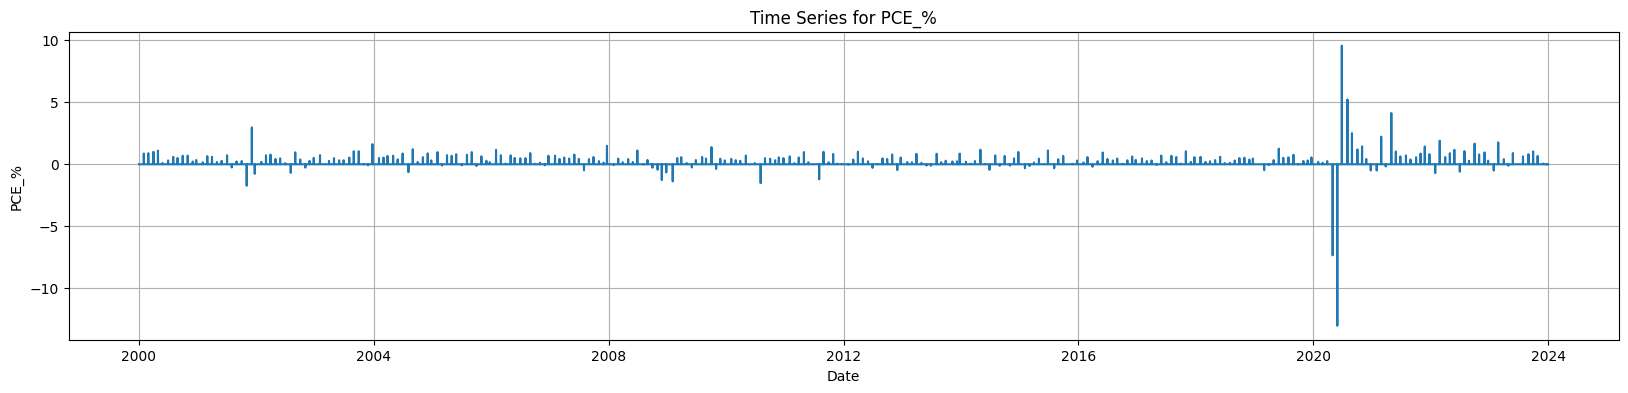

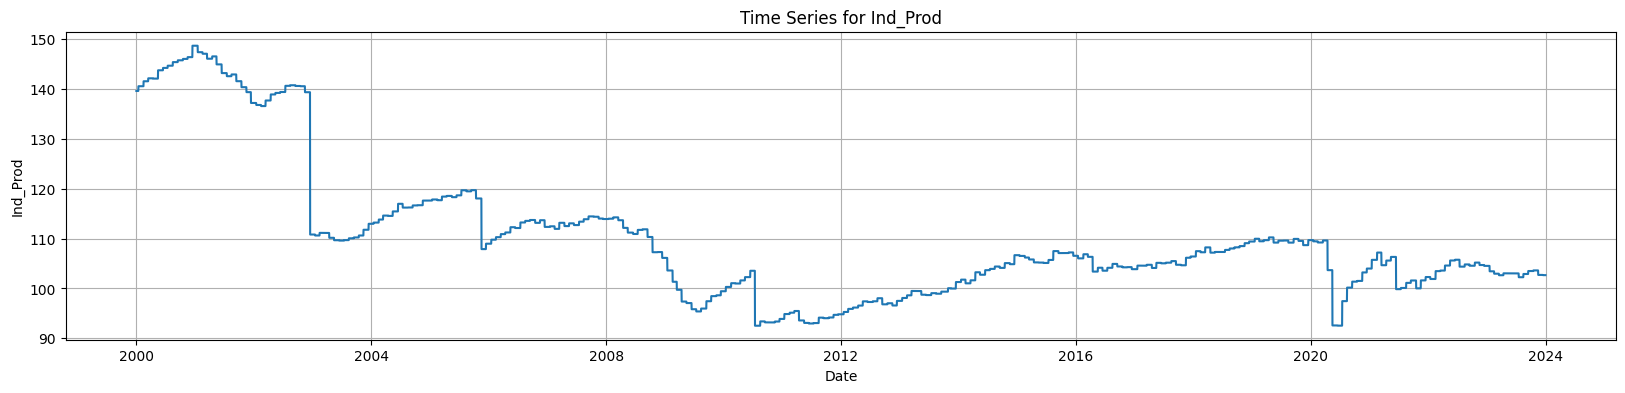

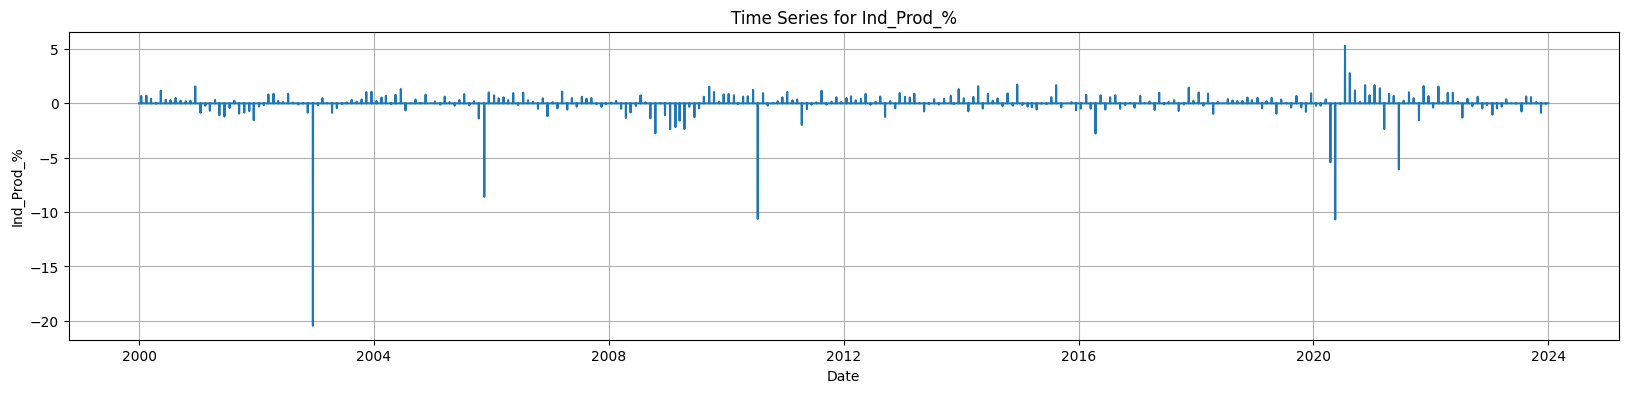

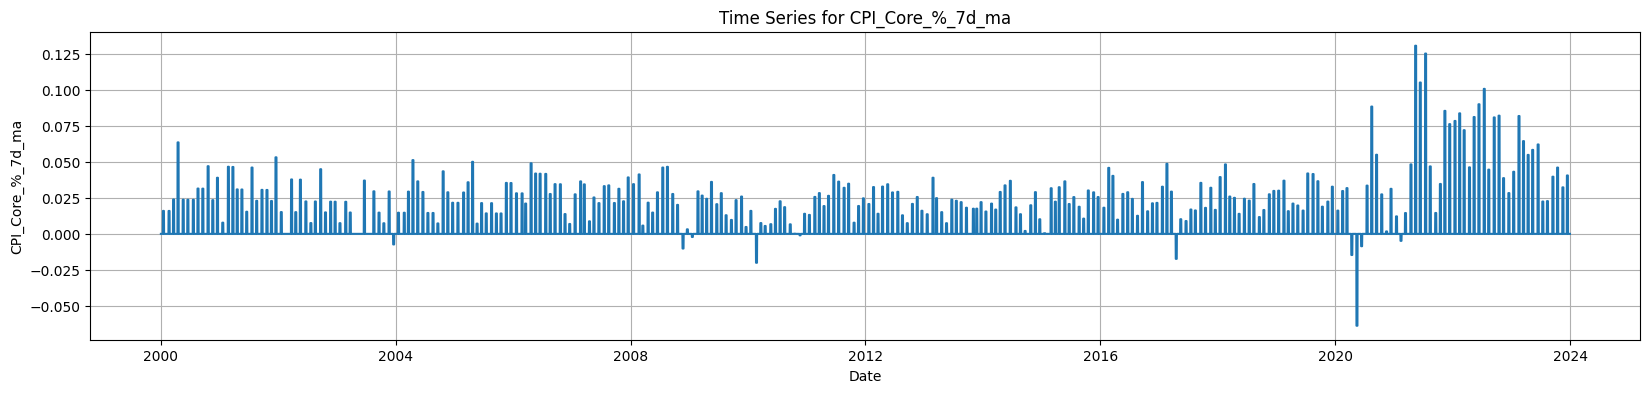

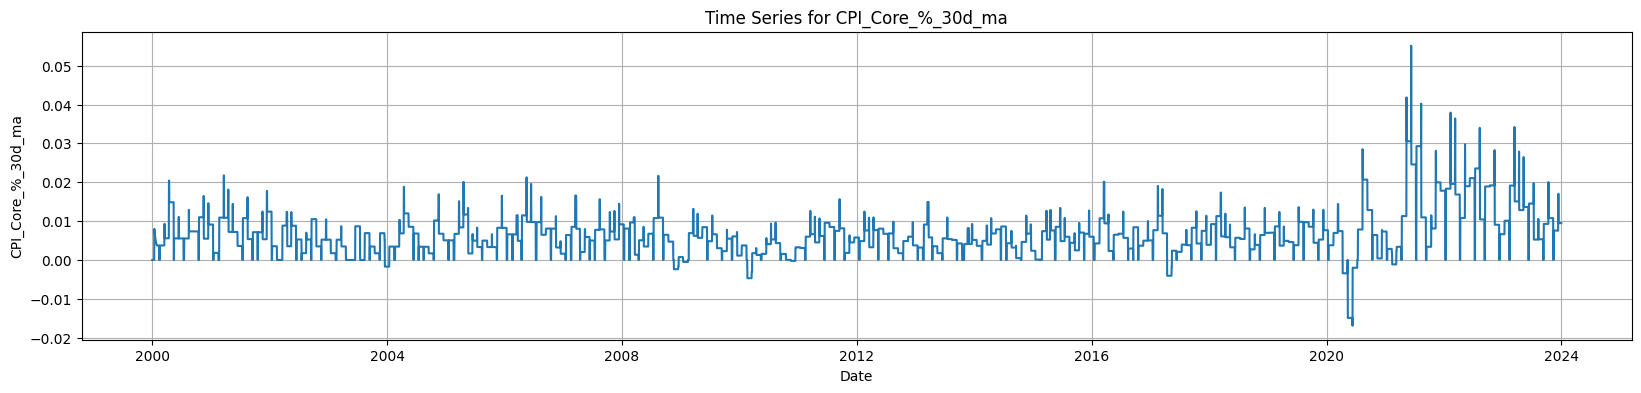

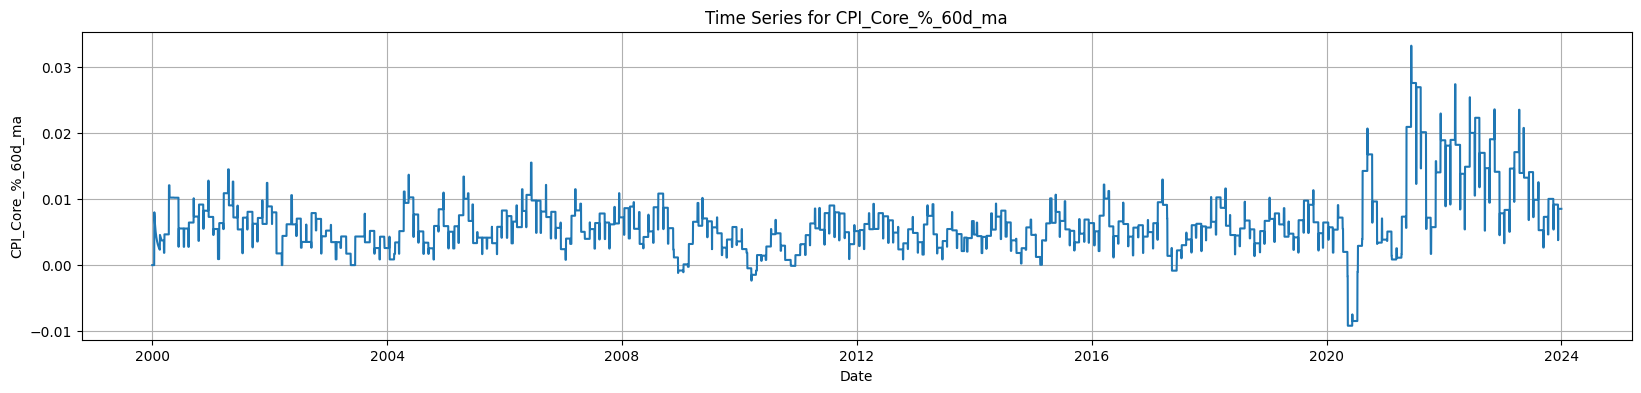

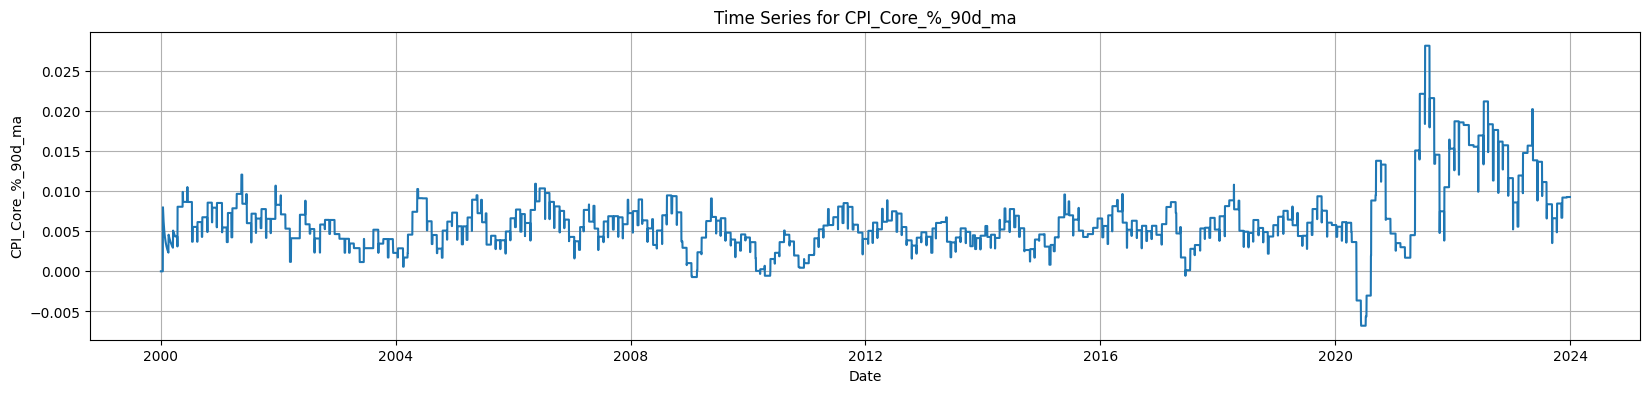

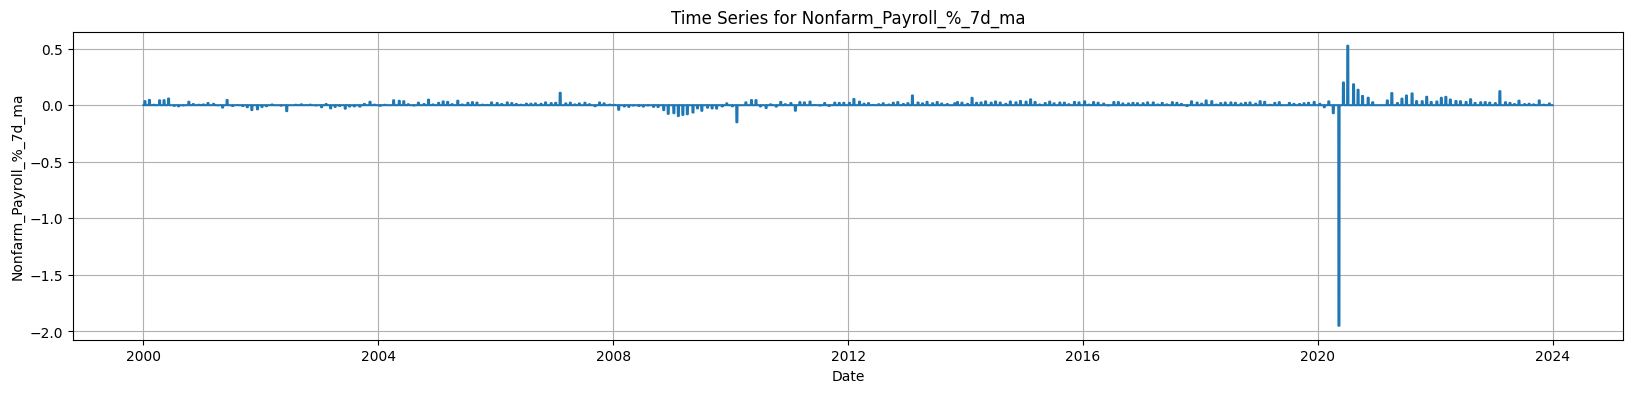

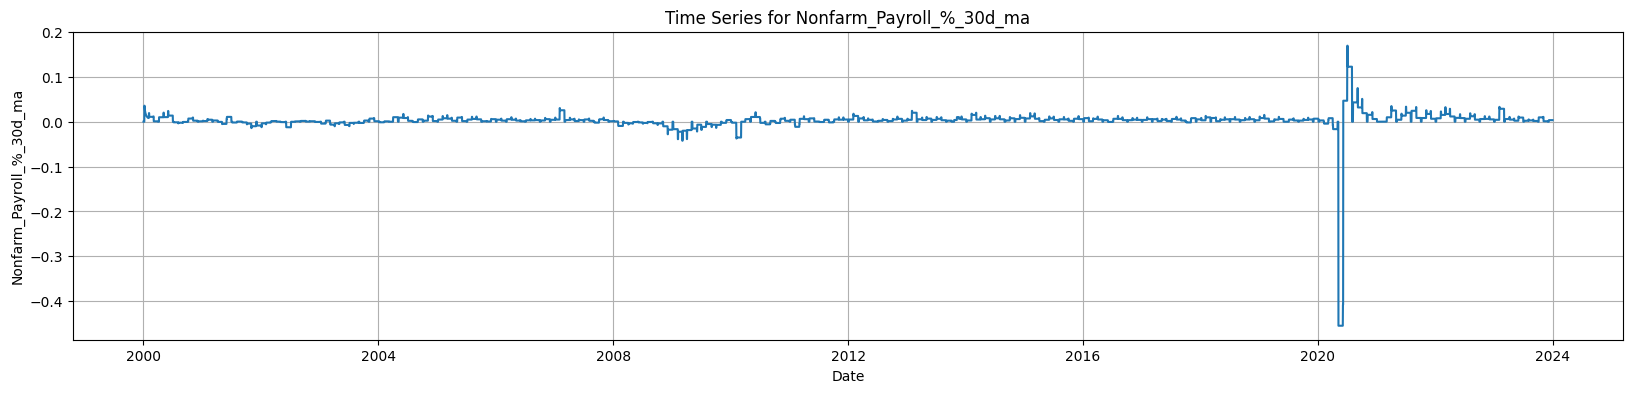

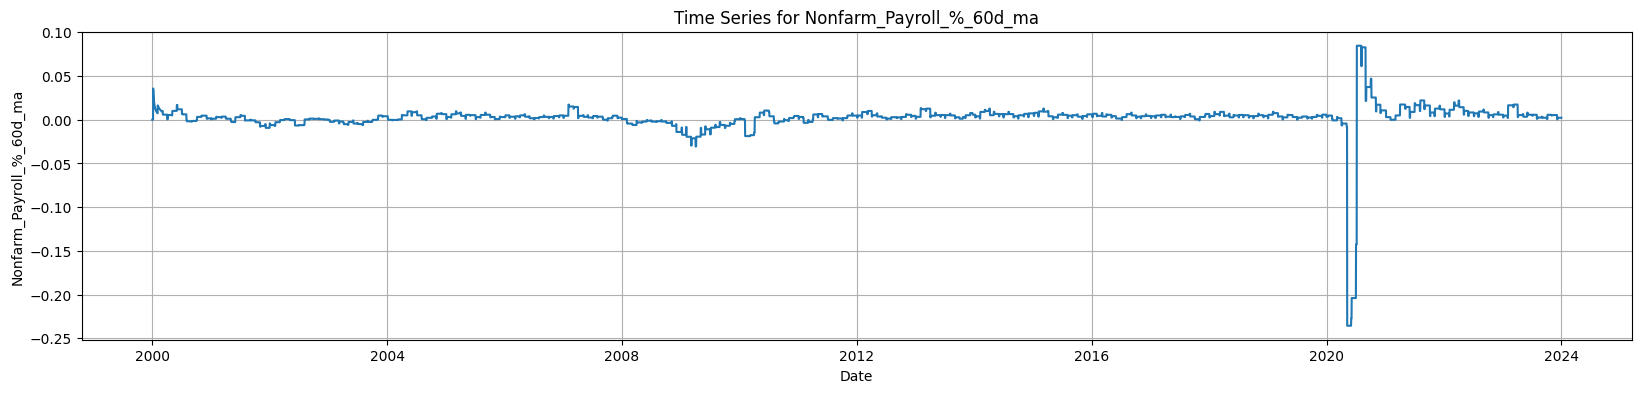

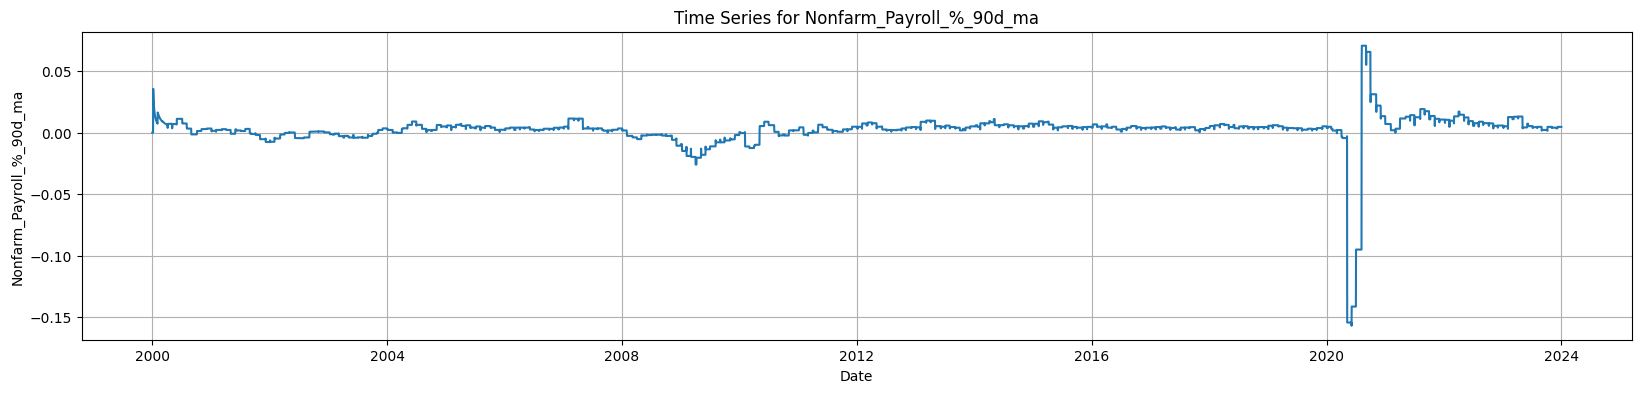

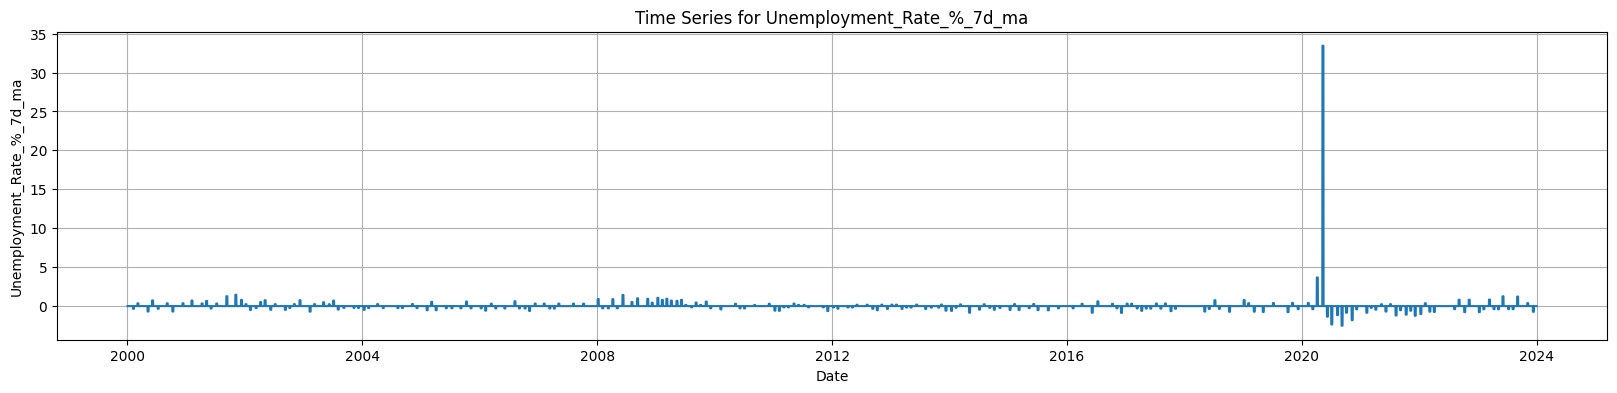

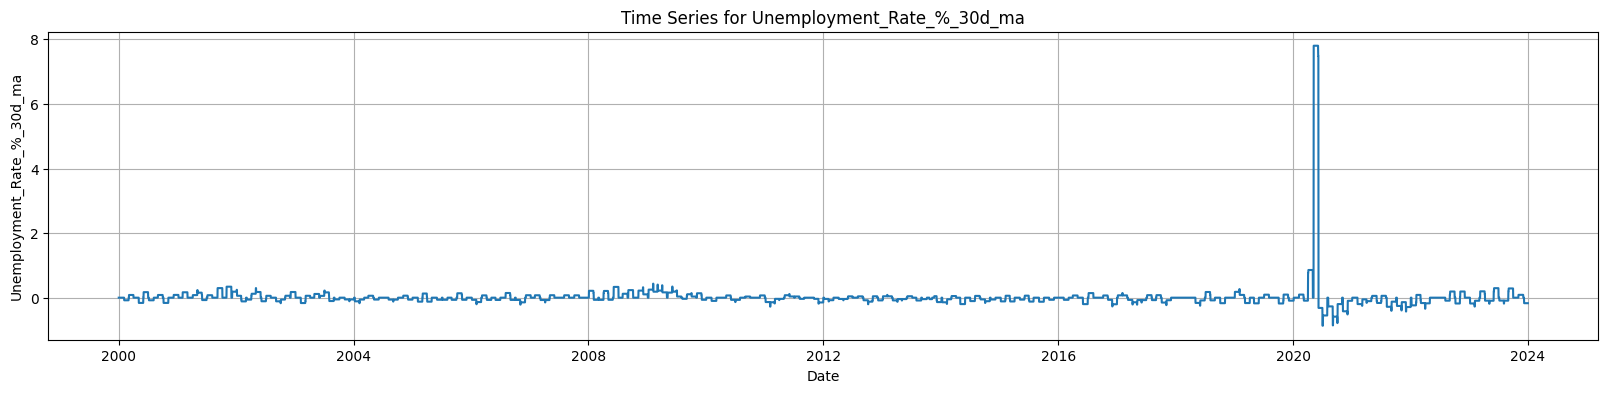

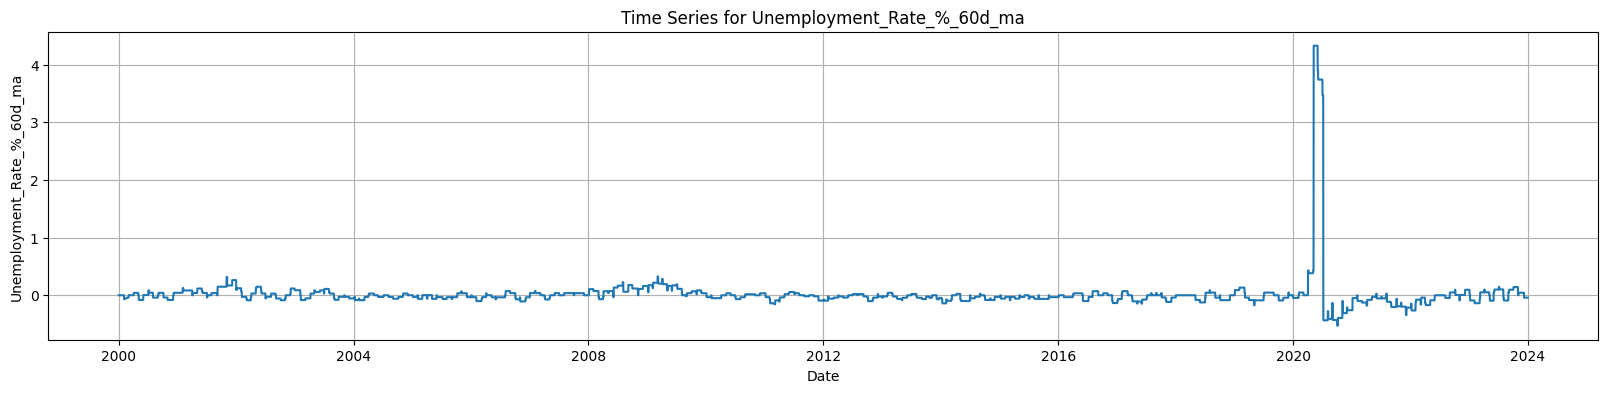

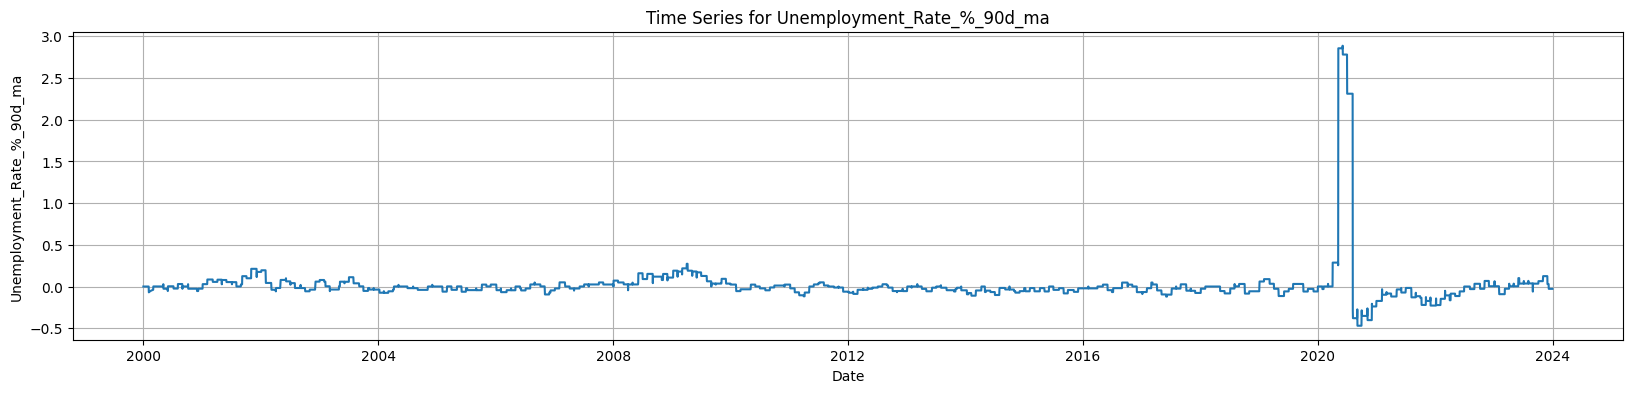

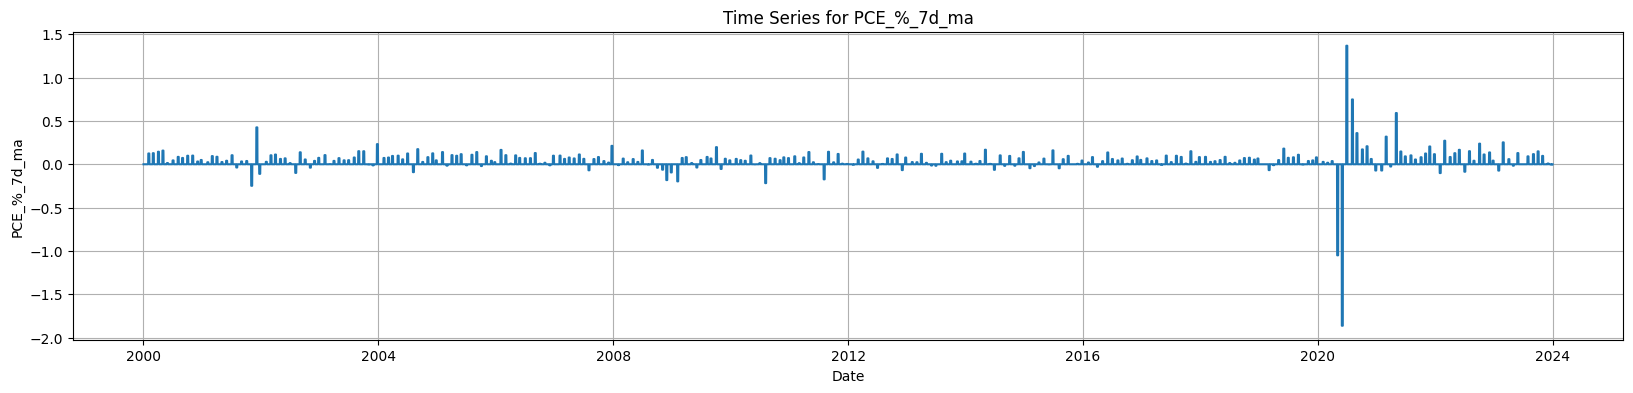

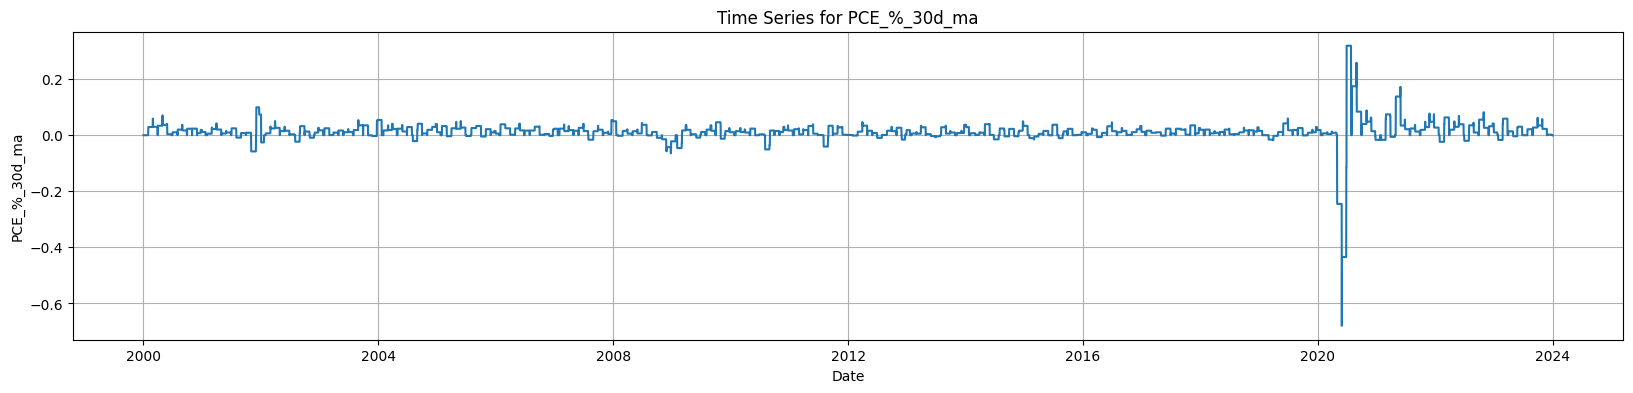

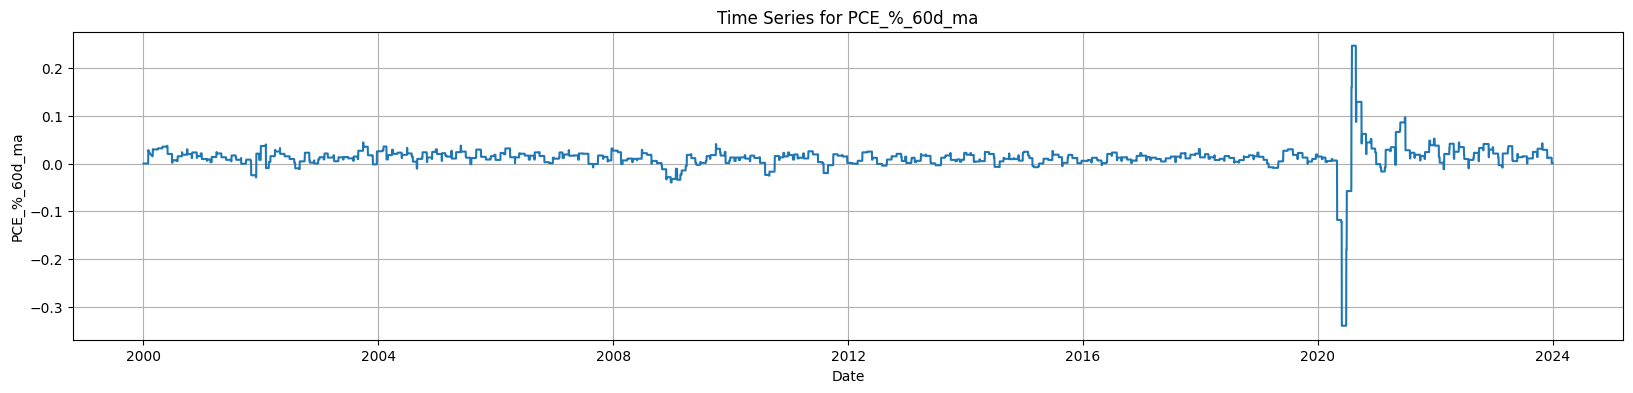

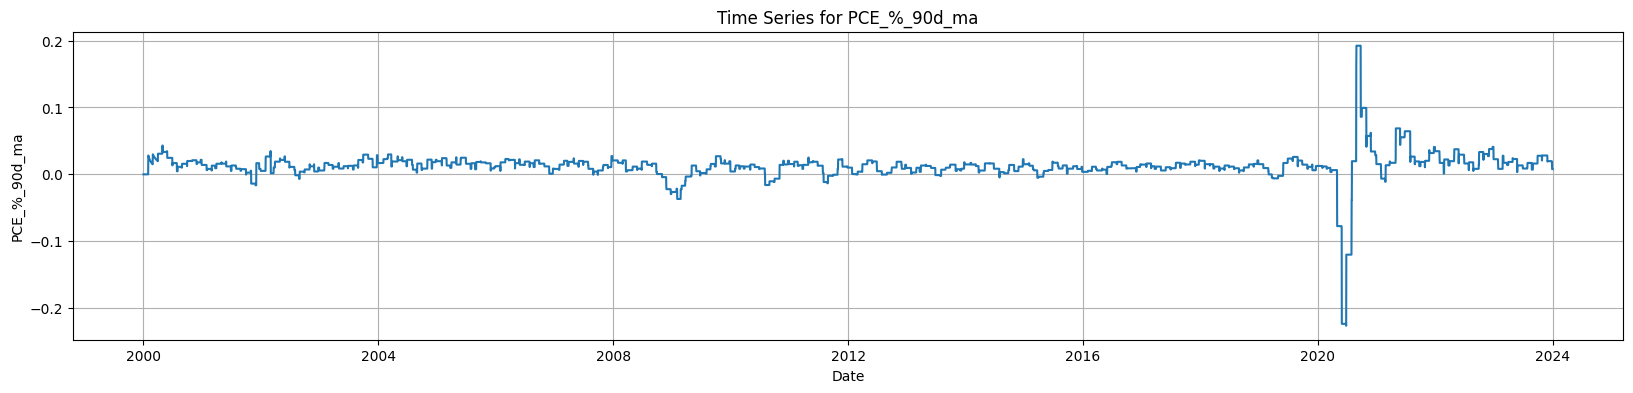

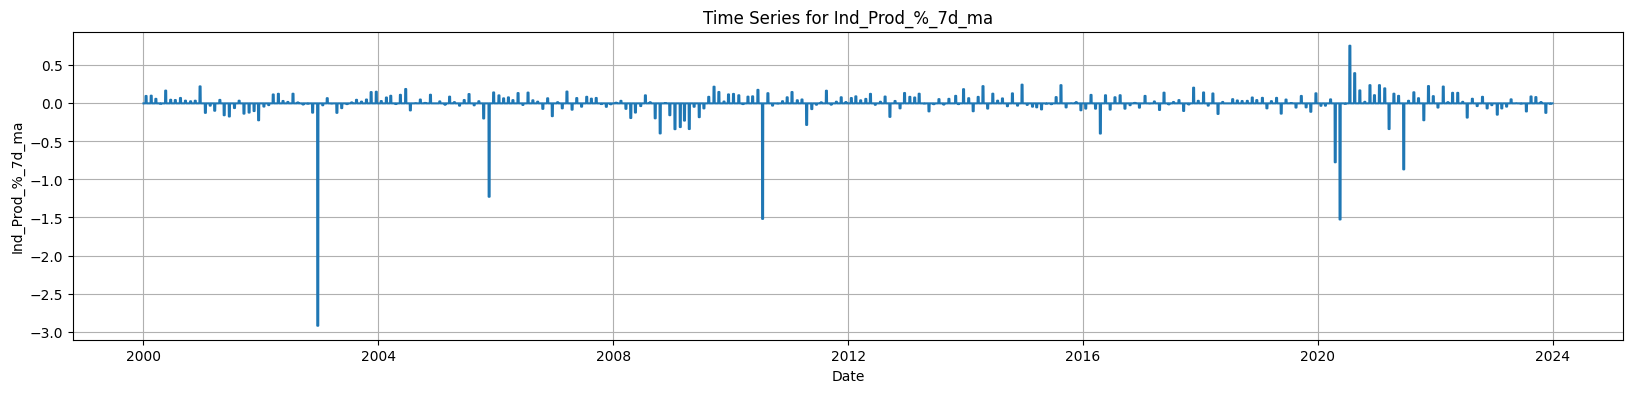

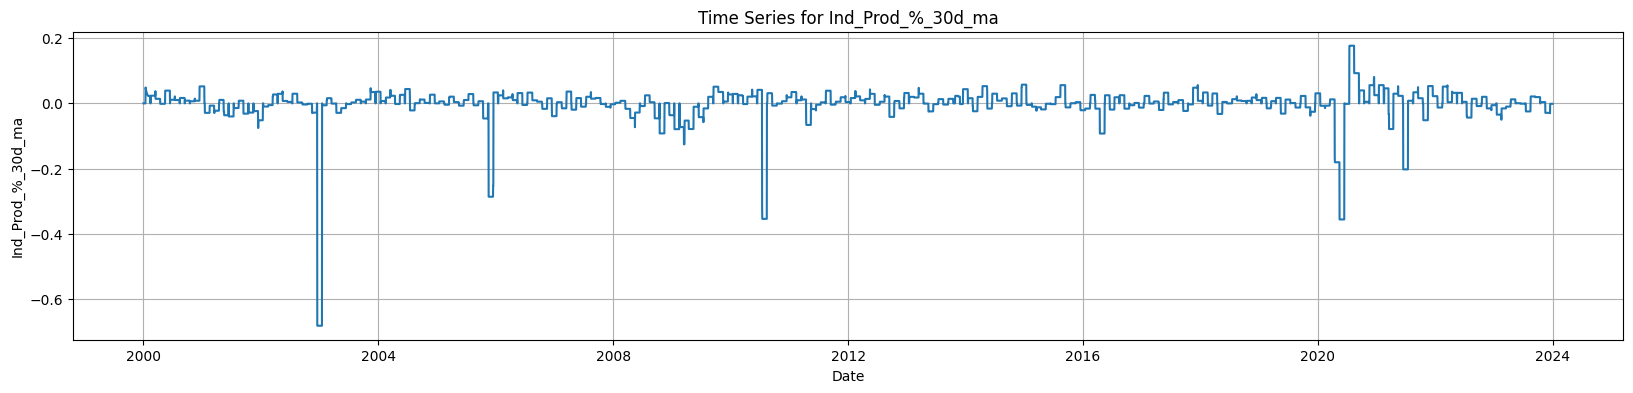

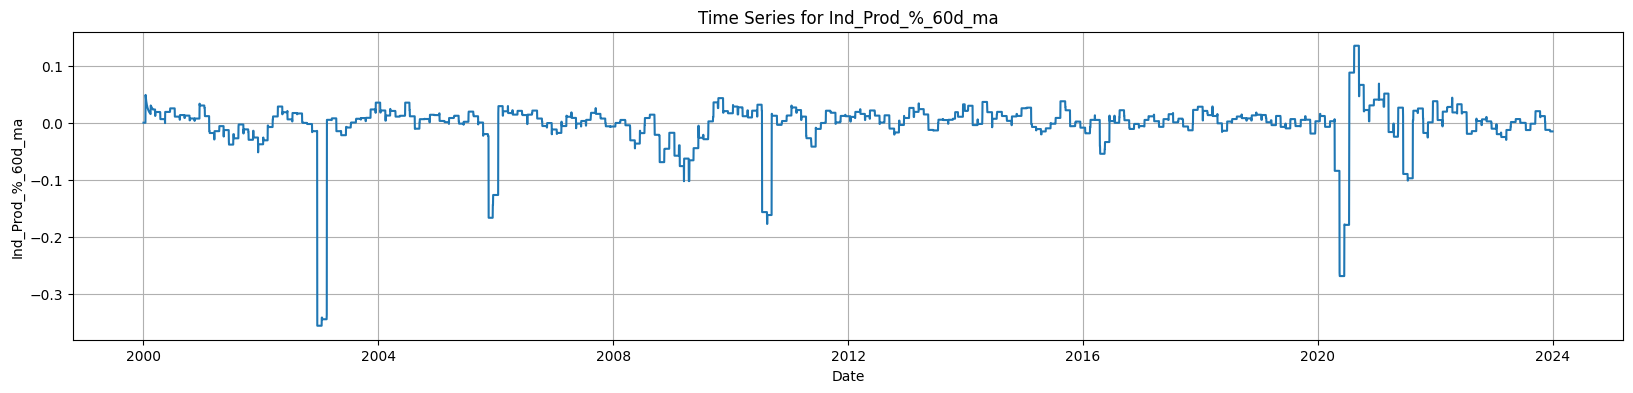

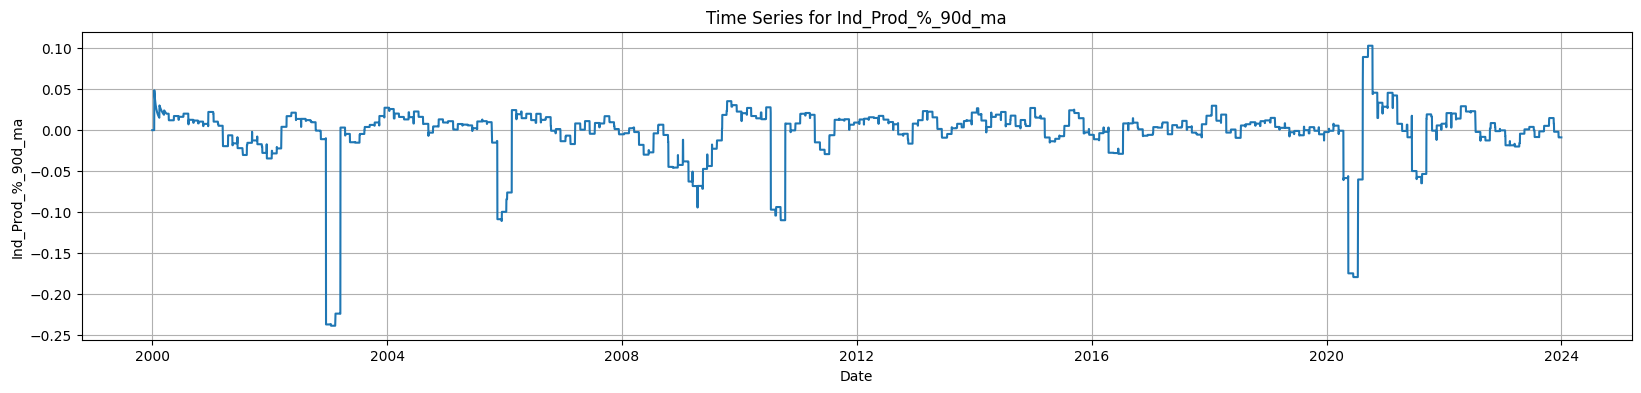

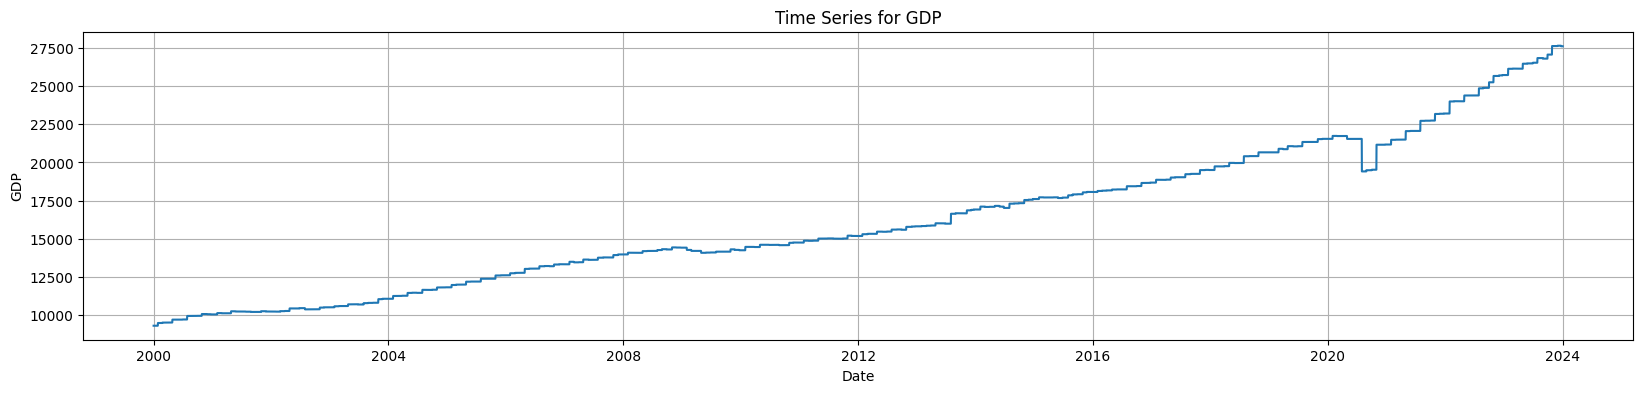

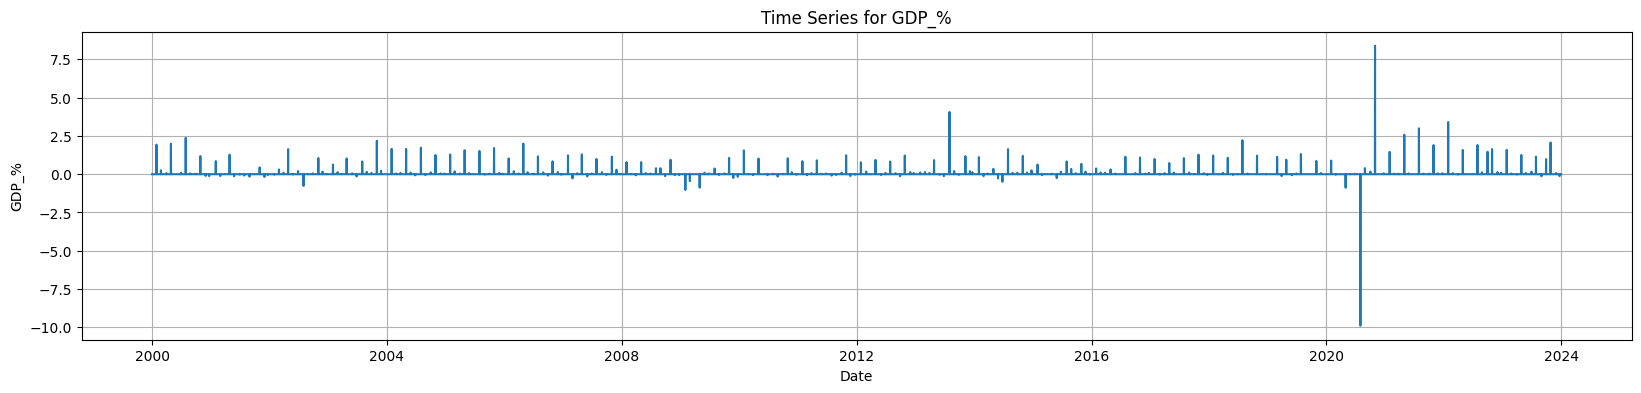

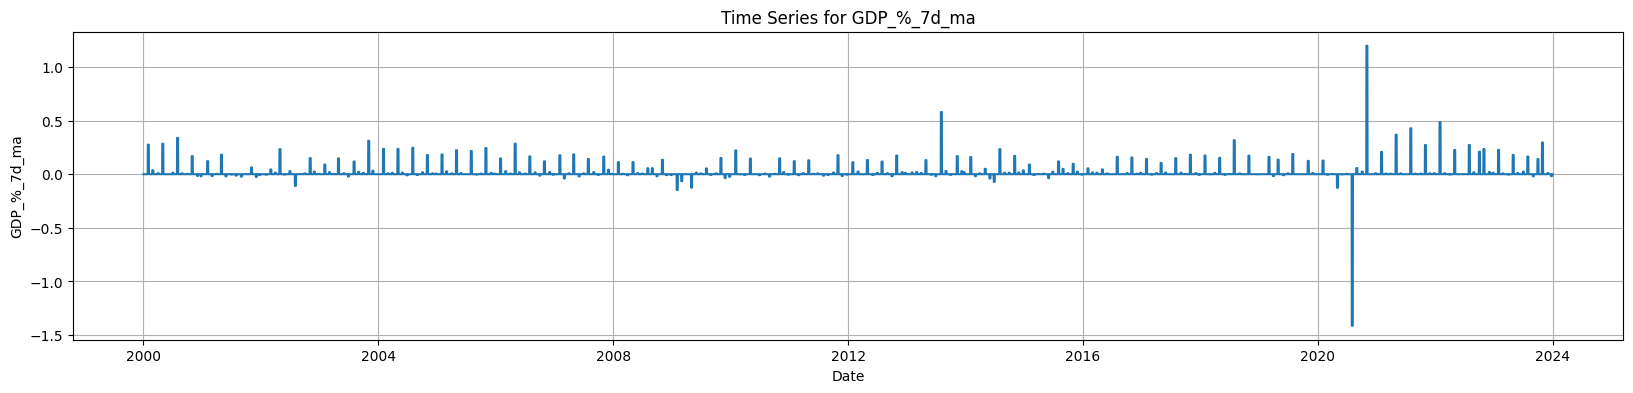

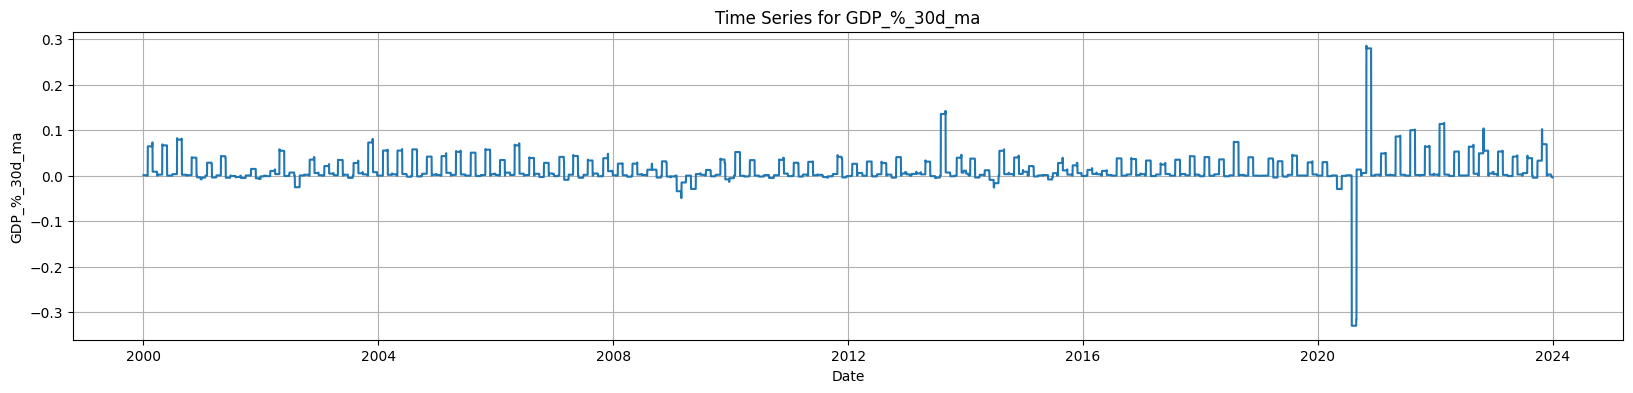

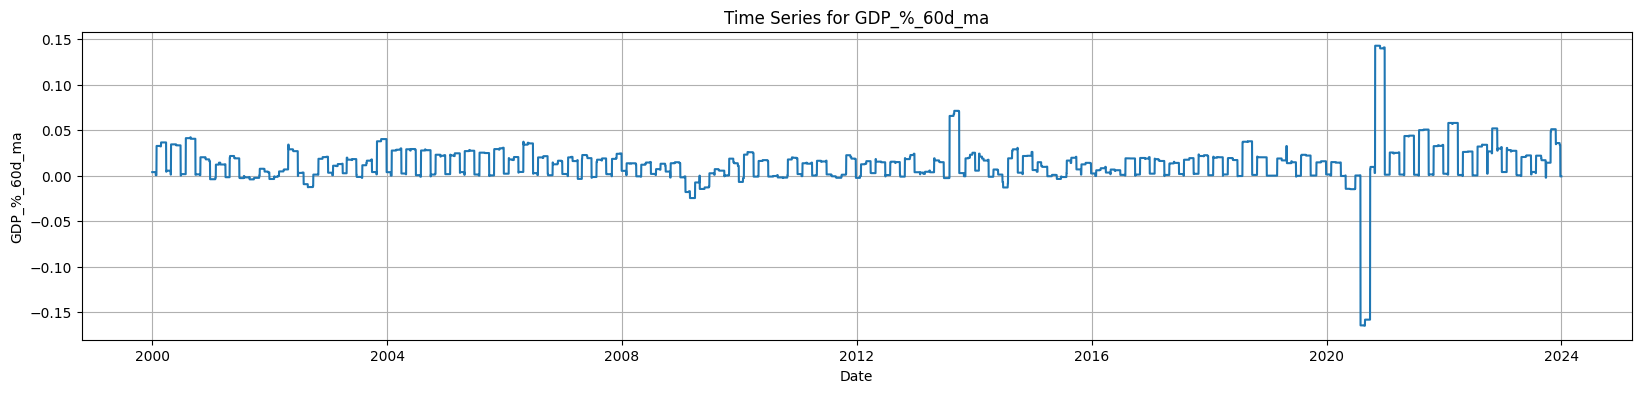

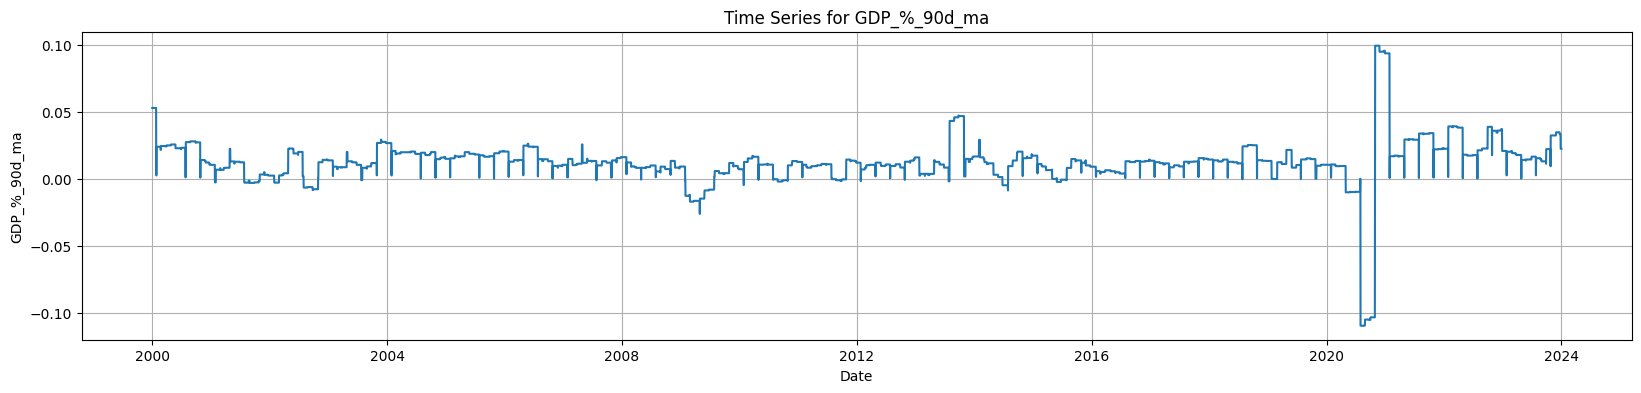

In [ ]:
for col in macro_df.columns:
    plt.figure(figsize=(20, 4))
    plt.plot(macro_df.index, macro_df[col], linestyle='-')
    plt.title(f'Time Series for {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# Join data

In [ ]:
# Convert indices to columns
yf_df.reset_index(inplace=True)
macro_df.reset_index(inplace=True)

# Rename macro_df_reset index column to Date to merge with yf_df
macro_df.rename(columns={'index':'Date'},inplace=True)

# Merge the DataFrames on the 'Date' column
main_df = pd.merge(yf_df, macro_df, on='Date', how='left')

# Set 'Date' back as the index
main_df.set_index('Date', inplace=True)

main_df.tail()

,Ticker,Adj Close,Close,High,Low,Open,Volume,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-29,YUM,130.0094,130.6600,131.2500,130.2100,130.4100,1196800.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZBH,121.7000,121.7000,122.4000,121.2400,121.4600,849600.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZBRA,273.3300,273.3300,276.3100,272.7700,274.7300,251300.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZION,43.4128,43.8700,44.6500,43.7200,44.6500,1420600.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225
2023-12-29,ZTS,196.9234,197.3700,198.0100,196.2500,196.6800,1007200.0000,5.3300,3.8400,312.2510,0.0000,157087.0000,0.0000,3.7000,0.0000,18858.9000,0.0000,102.6651,0.0000,0.0000,0.0095,0.0085,0.0093,0.0000,0.0035,0.0023,0.0047,0.0000,-0.1709,-0.0416,-0.0277,0.0000,0.0010,0.0005,0.0078,0.0000,-0.0014,-0.0152,-0.0088,27610.1280,0.0000,0.0000,-0.0041,-0.0008,0.0225


# Preprocessing

## Downcast to optimise memory footprint

In [ ]:
# memory usage
memory = main_df.memory_usage(deep=True).sum() / (1024**2)
print(f"""
    Memory usage of the DataFrame
    - - -
    MB: {memory:.2f}
    GB: {memory/1024:.2f}
""")


    Memory usage of the DataFrame
    - - -
    MB: 474.57
    GB: 0.46



In [ ]:
def downcast(df):

    # downcast float64 to float32
    float64_cols = df.select_dtypes(include=['float64']).columns
    df[float64_cols] = df[float64_cols].astype('float32')

    # downcast int64 to float32
    float64_cols = df.select_dtypes(include=['int64']).columns
    df[float64_cols] = df[float64_cols].astype('float32')

    return df

In [ ]:
main_df = downcast(main_df)

In [ ]:
# memory usage
memory = main_df.memory_usage(deep=True).sum() / (1024**2)
print(f"""
    Memory usage of the DataFrame
    - - -
    MB: {memory:.2f}
    GB: {memory/1024:.2f}
""")


    Memory usage of the DataFrame
    - - -
    MB: 627.17
    GB: 0.61



## Check missing values and outliers

In [ ]:
# check missing values
main_df.isna().sum()

Ticker                        0
Adj Close                     0
Close                         0
High                          0
Low                           0
Open                          0
Volume                        0
FFE_Rate                      0
10yr_UST                      0
CPI_Core                      0
CPI_Core_%                    0
Nonfarm_Payroll               0
Nonfarm_Payroll_%             0
Unemployment_Rate             0
Unemployment_Rate_%           0
PCE                           0
PCE_%                         0
Ind_Prod                      0
Ind_Prod_%                    0
CPI_Core_%_7d_ma              0
CPI_Core_%_30d_ma             0
CPI_Core_%_60d_ma             0
CPI_Core_%_90d_ma             0
Nonfarm_Payroll_%_7d_ma       0
Nonfarm_Payroll_%_30d_ma      0
Nonfarm_Payroll_%_60d_ma      0
Nonfarm_Payroll_%_90d_ma      0
Unemployment_Rate_%_7d_ma     0
Unemployment_Rate_%_30d_ma    0
Unemployment_Rate_%_60d_ma    0
Unemployment_Rate_%_90d_ma    0
PCE_%_7d

In [ ]:
# check outliers
main_df.describe()

,Adj Close,Close,High,Low,Open,Volume,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma
count,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000,2693815.0000
mean,67.7618,76.8274,77.7159,75.8950,76.8146,6614433.5000,1.7054,3.1422,234.0210,0.0094,139314.6719,0.0033,5.7643,0.0230,11584.2832,0.0179,109.0886,-0.0038,0.0066,0.0066,0.0064,0.0064,0.0024,0.0025,0.0025,0.0025,0.0156,0.0137,0.0143,0.0150,0.0123,0.0125,0.0125,0.0126,-0.0028,-0.0026,-0.0024,-0.0023,16637.1582,0.0184,0.0130,0.0129,0.0125,0.0126
std,157.1823,160.2438,162.1394,158.2794,160.1919,31818368.0000,1.9113,1.2952,33.4951,0.0536,8015.8687,0.2001,1.9914,3.2973,3095.4629,0.2960,12.7904,0.3968,0.0159,0.0055,0.0047,0.0042,0.0635,0.0298,0.0210,0.0164,1.0516,0.4909,0.3555,0.2941,0.0935,0.0433,0.0310,0.0240,0.1265,0.0600,0.0444,0.0361,4599.6343,0.2475,0.0781,0.0361,0.0236,0.0185
min,0.0305,0.0305,0.0305,0.0270,0.0302,0.0000,0.0400,0.5200,178.8000,-0.4475,129526.0000,-13.6468,3.4000,-17.6471,6416.7002,-13.0303,92.5354,-20.4583,-0.0639,-0.0169,-0.0092,-0.0068,-1.9495,-0.4549,-0.2357,-0.1572,-2.5210,-0.8688,-0.5285,-0.4700,-1.8615,-0.6793,-0.3396,-0.2264,-2.9226,-0.6819,-0.3552,-0.2388,9297.7998,-9.8930,-1.4133,-0.3298,-0.1649,-0.1098
25%,16.8689,23.6000,23.9300,23.2600,23.6000,908000.0000,0.1300,2.1000,207.6000,0.0000,131894.0000,0.0000,4.2000,0.0000,9360.5000,0.0000,101.6110,0.0000,0.0000,0.0035,0.0040,0.0042,0.0000,0.0000,0.0010,0.0018,0.0000,-0.0794,-0.0601,-0.0499,0.0000,0.0010,0.0060,0.0082,0.0000,-0.0101,-0.0084,-0.0062,13308.2998,0.0000,0.0000,0.0000,0.0011,0.0087
50%,33.5107,43.5875,44.0900,43.0500,43.5800,2070000.0000,1.0100,2.9500,231.2540,0.0000,137499.0000,0.0000,5.2000,0.0000,11258.0996,0.0000,105.7475,0.0000,0.0000,0.0058,0.0057,0.0058,0.0000,0.0038,0.0038,0.0041,0.0000,0.0000,0.0000,-0.0178,0.0000,0.0126,0.0129,0.0133,0.0000,0.0044,0.0053,0.0052,15811.0000,0.0000,0.0000,0.0023,0.0135,0.0128
75%,69.1601,80.5000,81.3400,79.6100,80.4900,4878600.0000,2.4100,4.1700,257.3050,0.0000,145858.0000,0.0000,6.7000,0.0000,13823.9004,0.0000,112.0991,0.0000,0.0000,0.0085,0.0078,0.0075,0.0000,0.0064,0.0057,0.0059,0.0000,0.0463,0.0362,0.0250,0.0000,0.0233,0.0202,0.0186,0.0000,0.0201,0.0154,0.0139,19956.8105,0.0000,0.0000,0.0277,0.0206,0.0174
max,7024.8198,7024.8198,7075.0000,6997.9102,7028.5000,7421640704.0000,7.0300,6.7900,312.2510,0.9166,157087.0000,3.6791,14.7000,234.0909,18864.6992,9.5669,148.6020,5.3035,0.1309,0.0551,0.0332,0.0281,0.5256,0.1694,0.0847,0.0708,33.4416,7.8030,4.3301,2.8867,1.3667,0.3189,0.2466,0.1924,0.7576,0.1768,0.1347,0.1030,27644.4629,8.3889,1.1984,0.2854,0.1427,0.0996


## Remove outliers

In [ ]:
# # specify number of std devs beyond which to clip
# deviations = 5 # adjust as needed

# # calculate mean and std dev
# mean = main_df[:end_valid_date].mean()
# std = main_df[:end_valid_date].std()

# # get clipping thresholds
# lower_bound = mean - std * deviations
# upper_bound = mean + std * deviations

# # clip df values
# main_df.clip(lower=lower_bound, upper=upper_bound)

# Feature engineering

## Technical indicators (volatility)

### Bollinger Bands

In [ ]:
def create_bbands(df, timeperiod=20, nbdevup=2, nbdevdn=2):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate bbands for current ticker
        upper_band, middle_band, lower_band = talib.BBANDS(
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            nbdevup=nbdevup,
            nbdevdn=nbdevdn,
            )

        # create bband columns for current ticker
        df.loc[idx, 'upper_bband'] = upper_band
        df.loc[idx, 'lower_bband'] = lower_band

    return df

### Average True Range

In [ ]:
def create_atr(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate atr for current ticker
        atr_values = talib.ATR(
            df.loc[idx, 'High'],
            df.loc[idx, 'Low'],
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create atr column for the current ticker
        df.loc[idx, 'ATR'] = atr_values

    return df

## Technical indicators (momentum)

### Moving Average Convergence Divergence

In [ ]:
def create_macd(df, fastperiod=12, slowperiod=26, signalperiod=9):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate macd for current ticker
        macd_line, signal_line, _ = talib.MACD(
            df.loc[idx, 'Adj Close'],
            fastperiod=fastperiod,
            slowperiod=slowperiod,
            signalperiod=signalperiod,
            )

        # create macd columns for the current ticker
        df.loc[idx, 'macd'] = macd_line
        df.loc[idx, 'macd_sginal'] = signal_line

    return df


### Relative Strength Index

In [ ]:
def create_rsi(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate rsi for current ticker
        rsi_values = talib.RSI(
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create rsi column for current ticker
        df.loc[idx, 'RSI'] = rsi_values

    return df

### Average Directional Index

In [ ]:
def create_adx(df, timeperiod=10):

    for ticker in tqdm(df['Ticker'].unique()):

        # prevent SettingWithCopyWarning
        df = df.copy()

        # get index of rows for the current ticker
        idx = df['Ticker'] == ticker

        # calculate adx for current ticker
        adx_values = talib.ADX(
            df.loc[idx, 'High'],
            df.loc[idx, 'Low'],
            df.loc[idx, 'Adj Close'],
            timeperiod=timeperiod,
            )

        # create adx column for current ticker
        df.loc[idx, 'ADX'] = adx_values

    return df

## Target variable

In [ ]:
def create_target(df):

  # prevent SettingWithCopyWarning
  df = df.copy()

  # define positive and negative class
  df['return'] = df[['Adj Close', 'Ticker']].groupby('Ticker', as_index=False, sort=False).pct_change() * 100
  df['return_class'] = df['return'].apply(lambda x: 1 if x > 0 else 0)

  # create target variable y
  df['y'] = df[['return_class', 'Ticker']].groupby('Ticker', as_index=False, sort=False).shift(-1)

  # clean up df
  df.dropna(inplace=True)
  gc.collect()

  return df

## Aggregate features

In [ ]:
def aggregate_features(df, columns):

    # prevent SettingWithCopyWarning
    df = df.copy()

    # temporary create unique index labels
    df.reset_index(inplace=True)

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Date']

    # rename columns
    agg_mean_cols = [f'{col}_agg_mean' for col in columns]
    agg_std_cols = [f'{col}_agg_std' for col in columns]

    # compute daily unweighted aggregate mean and std for entire s&p500
    df[agg_mean_cols] = df[groupby_cols].groupby(['Date'])[columns].transform('mean')
    df[agg_std_cols] = df[groupby_cols].groupby(['Date'])[columns].transform('std')

    # reset index to original datetime
    df.set_index('Date', inplace=True)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Return features

In [ ]:
def return_features(df, columns, periods):

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # compute percentage changes between periods
    for period in tqdm(range(1, periods+1)):
        new_cols = [f'{col}_return_{period}t' for col in columns]
        df[new_cols] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).pct_change(periods=period)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Lagged features

In [ ]:
def lagged_features(df, columns, lags):

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # create features containing lagged values
    for lag in tqdm(range(1, lags+1)):
        new_cols = [f'{col}_t-{lag}' for col in columns]
        df[new_cols] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).shift(periods=lag)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

## Rolling features

In [ ]:
def rolling_features(df, columns, windows):

    # prevent SettingWithCopyWarning
    df = df.copy()

    # temporary create unique index labels
    df.reset_index(inplace=True)

    # create list to allow grouping by ticker
    groupby_cols = columns + ['Ticker']

    # define column names
    mean_cols = [f'{col}_mean' for col in columns]
    std_cols = [f'{col}_std' for col in columns]
    min_cols = [f'{col}_min' for col in columns]
    max_cols = [f'{col}_max' for col in columns]

    # create rolling mean, std, min and max features
    for window in tqdm(windows):

        mean_colnames = [f'{col}_{window}t' for col in mean_cols]
        df[mean_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).mean()[columns]

        std_colnames = [f'{col}_{window}t' for col in std_cols]
        df[std_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).std()[columns]

        min_colnames = [f'{col}_{window}t' for col in min_cols]
        df[min_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).min()[columns]

        max_colnames = [f'{col}_{window}t' for col in max_cols]
        df[max_colnames] = df[groupby_cols].groupby('Ticker', as_index=False, sort=False).rolling(window=window).max()[columns]

    # reset index to original datetime
    df.set_index('Date', inplace=True)

    # clean up df
    df.dropna(inplace=True)
    gc.collect()

    return df

# Augment data

In [ ]:
# list of features for which to compute daily aggregate statistics
agg_cols = ['Adj Close', 'Volume']

# number of periods and list of features for which to calculate returns
return_periods_far = 10
return_cols_far = ['Adj Close']
return_periods_near = 5
return_cols_near = ['Open', 'High', 'Low', 'Volume']

# number of lags and list of features on which to perform lagged operation
lagged_periods = 10
lagged_cols = ['return', 'return_class']

# window horizons and list of features for which to calculate rolling statistics
rolling_windows = [5, 10, 20, 60]
rolling_cols = ['return']

In [ ]:
def feature_engineering(df):

    df = create_bbands(df, timeperiod=20, nbdevup=2, nbdevdn=2)
    df = create_atr(df, timeperiod=20)
    df = create_macd(df, fastperiod=12, slowperiod=26, signalperiod=9)
    df = create_rsi(df, timeperiod=15)
    df = create_adx(df, timeperiod=10)
    df = create_target(df)
    df = aggregate_features(df, agg_cols)
    df = return_features(df, return_cols_far, return_periods_far)
    df = return_features(df, return_cols_near, return_periods_near)
    df = lagged_features(df, lagged_cols, lagged_periods)
    df = rolling_features(df, rolling_cols, rolling_windows)

    return df

In [ ]:
%%time

# run main df through our custom feature engineering pipeline
main_df = feature_engineering(main_df)

100%|██████████| 4/4 [00:50<00:00, 12.70s/it]


CPU times: user 17min 3s, sys: 5min 13s, total: 22min 16s
Wall time: 23min 15s


In [ ]:
# handle missing values
main_df.replace([np.inf, -np.inf], np.nan, inplace=True)
main_df.ffill(inplace=True)
main_df.dropna(inplace=True)

# display dataframe size
print(f'DataFrame rows by columns: {main_df.shape}')

DataFrame rows by columns: (2633373, 125)


# Save and load in main dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # save final feature engineered df containing sp500 and fred data
# sp500_fred_data = '/content/drive/MyDrive/Colab Notebooks/Capstone/sp500_fred_data.parquet'
# main_df.to_parquet(sp500_fred_data, compression='gzip', index=True)

In [ ]:
# load in from personal google drive
file_path = "/content/drive/My Drive/Colab Notebooks/Capstone/sp500_fred_data.parquet"
main_df = pd.read_parquet(file_path)

In [ ]:
main_df[main_df['Ticker']=='A'].head()

,Ticker,Adj Close,Close,High,Low,Open,Volume,FFE_Rate,10yr_UST,CPI_Core,CPI_Core_%,Nonfarm_Payroll,Nonfarm_Payroll_%,Unemployment_Rate,Unemployment_Rate_%,PCE,PCE_%,Ind_Prod,Ind_Prod_%,CPI_Core_%_7d_ma,CPI_Core_%_30d_ma,CPI_Core_%_60d_ma,CPI_Core_%_90d_ma,Nonfarm_Payroll_%_7d_ma,Nonfarm_Payroll_%_30d_ma,Nonfarm_Payroll_%_60d_ma,Nonfarm_Payroll_%_90d_ma,Unemployment_Rate_%_7d_ma,Unemployment_Rate_%_30d_ma,Unemployment_Rate_%_60d_ma,Unemployment_Rate_%_90d_ma,PCE_%_7d_ma,PCE_%_30d_ma,PCE_%_60d_ma,PCE_%_90d_ma,Ind_Prod_%_7d_ma,Ind_Prod_%_30d_ma,Ind_Prod_%_60d_ma,Ind_Prod_%_90d_ma,GDP,GDP_%,GDP_%_7d_ma,GDP_%_30d_ma,GDP_%_60d_ma,GDP_%_90d_ma,upper_bband,lower_bband,ATR,macd,macd_sginal,RSI,ADX,return,return_class,y,Adj Close_agg_mean,Volume_agg_mean,Adj Close_agg_std,Volume_agg_std,Adj Close_return_1t,Adj Close_return_2t,Adj Close_return_3t,Adj Close_return_4t,Adj Close_return_5t,Adj Close_return_6t,Adj Close_return_7t,Adj Close_return_8t,Adj Close_return_9t,Adj Close_return_10t,Open_return_1t,High_return_1t,Low_return_1t,Volume_return_1t,Open_return_2t,High_return_2t,Low_return_2t,Volume_return_2t,Open_return_3t,High_return_3t,Low_return_3t,Volume_return_3t,Open_return_4t,High_return_4t,Low_return_4t,Volume_return_4t,Open_return_5t,High_return_5t,Low_return_5t,Volume_return_5t,return_t-1,return_class_t-1,return_t-2,return_class_t-2,return_t-3,return_class_t-3,return_t-4,return_class_t-4,return_t-5,return_class_t-5,return_t-6,return_class_t-6,return_t-7,return_class_t-7,return_t-8,return_class_t-8,return_t-9,return_class_t-9,return_t-10,return_class_t-10,return_mean_5t,return_std_5t,return_min_5t,return_max_5t,return_mean_10t,return_std_10t,return_min_10t,return_max_10t,return_mean_20t,return_std_20t,return_min_20t,return_max_20t,return_mean_60t,return_std_60t,return_min_60t,return_max_60t
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-20,A,44.6698,52.6645,54.2740,48.9092,49.3115,11718176.0000,6.5100,6.0000,180.9000,0.0000,131654.0000,0.0000,4.1000,0.0000,6676.1001,0.0000,144.1590,0.0000,0.0237,0.0055,0.0055,0.0086,0.0000,0.0137,0.0120,0.0113,0.0000,0.1709,0.0042,0.0028,0.0000,0.0033,0.0201,0.0246,0.0473,0.0110,0.0251,0.0163,9697.5996,0.0000,0.0000,0.0001,0.0333,0.0229,49.0295,34.9709,10.8025,-2.0336,-2.5162,50.1049,13.3526,8.2721,1,1.0000,21.2018,5103195.0000,55.4596,27890983.9483,0.0827,0.1756,0.1166,0.0867,0.0661,0.1155,0.0388,0.0651,0.0989,0.0370,0.1097,0.0996,0.1006,0.7204,0.0415,0.1399,0.1028,0.8062,0.0147,0.1168,0.0550,0.7238,-0.0256,0.0612,0.0205,1.0885,0.0688,0.0575,0.0601,0.5182,8.5828,1.0000,-5.0237,0.0000,-2.6752,0.0000,-1.9005,0.0000,4.6402,1.0000,-6.8783,0.0000,2.5317,1.0000,3.1716,1.0000,-5.6338,0.0000,-10.1266,0.0000,1.4511,6.4724,-5.0237,8.5828,0.5087,5.7015,-6.8783,8.5828,1.1077,7.7597,-10.1266,16.5254,-0.5497,7.3700,-14.7987,18.2857
2000-06-21,A,47.6275,56.1516,57.1799,52.4410,52.4857,8977676.0000,6.4900,6.0300,180.9000,0.0000,131654.0000,0.0000,4.1000,0.0000,6676.1001,0.0000,144.1590,0.0000,0.0000,0.0055,0.0055,0.0086,0.0000,0.0137,0.0120,0.0113,0.0000,0.1709,0.0042,0.0028,0.0000,0.0033,0.0201,0.0246,0.0473,0.0110,0.0251,0.0163,9697.5996,0.0000,0.0000,0.0001,0.0333,0.0229,49.3244,35.9198,10.8879,-1.4363,-2.3002,53.8479,13.8770,6.6214,1,0.0000,21.2035,4964995.0000,55.5537,28131345.6023,0.0662,0.1544,0.2535,0.1905,0.1587,0.1367,0.1894,0.1076,0.1356,0.1716,0.0644,0.0535,0.0722,-0.2339,0.1811,0.1585,0.1801,0.3180,0.1086,0.2009,0.1825,0.3838,0.0800,0.1766,0.1311,0.3207,0.0371,0.1180,0.0942,0.6000,8.2721,1.0000,8.5828,1.0000,-5.0237,0.0000,-2.6752,0.0000,-1.9005,0.0000,4.6402,1.0000,-6.8783,0.0000,2.5317,1.0000,3.1716,1.0000,-5.6338,0.0000,3.1555,6.4912,-5.0237,8.5828,1.7342,5.5496,-6.8783,8.5828,1.7895,7.6060,-10.1266,16.5254,-0.3595,7.4058,-14.7987,18.2857
2000-06-22,A,45.9591,54.1845,57.0905,53.2010,57.0458,6733747.0000,6.4700,6.1100,180.9000,0.0000,131654.0000,0.0000,4.1000,0.0000,6676.1001,0.0000,144.1590,0.0000,0.0000,0.00

# Check class imbalance

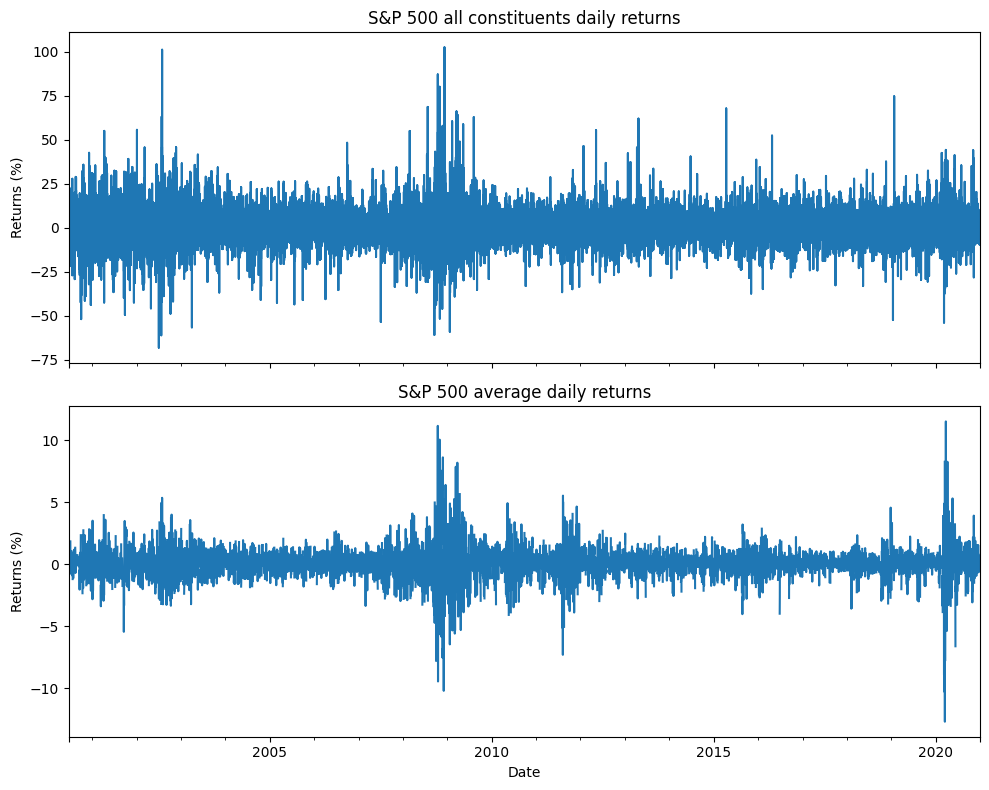

In [ ]:
# create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# plot returns for all S&P 500 stocks overlayed
main_df['return_t-1'][:end_valid_date].plot(ax=axs[0])
axs[0].set_title('S&P 500 all constituents daily returns')
axs[0].set_ylabel('Returns (%)')

# plot returns for S&P 500 average
main_df['return_t-1'][:end_valid_date].resample('D').mean().plot(ax=axs[1])
axs[1].set_title('S&P 500 average daily returns')
axs[1].set_ylabel('Returns (%)')

# show plot
plt.tight_layout()
plt.show()

In [ ]:
# check class imbalance
print(f"""
    Positive class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[1]:.4f}
    Negative class: {main_df['y'][:end_valid_date].value_counts(normalize=True)[0]:.4f}
""")


    Positive class: 0.5147
    Negative class: 0.4853



# Feature selection

## Preprocessing

In [ ]:
main_df = downcast(main_df)

In [ ]:
# partition main df into train validation test sets
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

# df used for trading performance review
perf_df = test_df[['Ticker','Adj Close','Adj Close_return_1t']]

In [ ]:
#find the amount of data we can run on Google Colab

# Take a small fraction of the data, e.g., 5% or 10%
sample_df = main_df.sample(frac=0.25, random_state=42)

# Split this smaller dataset into X and y
X_sample = sample_df.drop('y', axis=1)
y_sample = sample_df['y']

# Try preprocessing this smaller dataset
try:
    X_sample_preprocessed = preprocessor.fit_transform(X_sample)
    print("Preprocessing succeeded on a smaller dataset.")
except Exception as e:
    print("Preprocessing failed:", str(e))

del sample_df
del X_sample
del y_sample

Preprocessing failed: name 'preprocessor' is not defined


In [ ]:
#shorten data for RandomSearchCV to avoid crashing Google Colab
rf_start_date = '2013-01-01'
rf_train = train_df[rf_start_date:]
rf_X_train = rf_train.drop('y', axis=1)
rf_y_train = rf_train['y']

## Hyperparameter Tuning (Very heavy to run. Best params saved in the next section)

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
    # TargetEncoder(),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

In [ ]:
params = {
    'model__n_estimators': [100, 250, 400],
    'model__max_depth': [5, 10, 15],
    'model__max_samples': [0.3, 0.5, 0.7],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252)

rf_gs = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    n_iter=20,
    scoring='precision',
    n_jobs=4,
    refit=True,
    cv=tscv,
    verbose=2,
    random_state=42,
)

In [ ]:
#This takes very long time.
rf_gs.fit(rf_X_train, rf_y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=True,
                                                                                                              strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_colum...
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7b48e0039180>)])),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=4,
                   param_distributions={'model__max_depth': [5, 10, 15],
                                        'model__max_samples': [0.3, 0.5, 0.7],
                                        'model__n_estimators': [100, 250, 400]},
                   random_state=42, scoring='precision', verbose=2)

In [ ]:
best_rf = rf_gs.best_estimator_

# Get the best hyperparameters from the best_rf model
best_parameters = best_rf.get_params()

print("Best Parameters:")
for parameter, value in best_parameters.items():
    print(f"{parameter}: {value}")

## Refitting model using full train data with best params (heavy to run)

In [ ]:
#set best parameters based on the RandomSearchCV result
best_params = {
    'model__n_estimators': 100,
    'model__max_depth': 15,
    'model__max_samples': 0.7,
}

rf_pipeline.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eb00ded3910>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eb00c4d94e0>)])),
                ('model',
                 RandomForestClassifier(max_depth=15, max_samples=0.7,
                                        random_state=42))])

In [ ]:
best_rf = rf_pipeline.fit(X_train, y_train)

In [ ]:
rf_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/best_rf_model.joblib'
dump(best_rf, rf_to_save)

print(f"Model saved to {rf_to_save}")

### Retrieve fitted model

In [ ]:
# Load the model from the file
rf_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/best_rf_model.joblib'
best_rf = load(rf_load_from)

## Evaluation and Cross-Validation

In [ ]:
y_pred = best_rf.predict(X_valid)

precision = precision_score(y_valid, y_pred, average='binary')

print(f"Precision Score: {precision}")

Precision Score: 0.5256099429012101


In [ ]:
# Clone the best model to use it for cross-validation
rf_clone = clone(best_rf)

# cross validate
tscv = TimeSeriesSplit(n_splits=3, test_size=252)
cv_results = cross_validate(rf_clone, X_train, y_train, cv=tscv, return_estimator=True)

# Collect all feature importances from each fold
all_importances = [estimator.named_steps['model'].feature_importances_ for estimator in cv_results['estimator']]

In [ ]:
rf_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/rf_cv_result.joblib'
dump(cv_results, rf_to_save)

print(f"Model saved to {rf_to_save}")

Model saved to /content/drive/My Drive/Colab Notebooks/Capstone/rf_cv_result.joblib


## removing features under threshold

In [ ]:
# Load the model from the file
rf_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/rf_cv_result.joblib'
cv_results = load(rf_load_from)
all_importances = [estimator.named_steps['model'].feature_importances_ for estimator in cv_results['estimator']]

In [ ]:
# Convert the importances into a DataFrame for easier plotting
feature_names = X_train.columns.tolist()
df_importances = pd.DataFrame(all_importances, columns=feature_names)
mean_importances = df_importances.mean().sort_values(ascending=False)

# Create a DataFrame for sorted features by their average importance
sorted_features = pd.DataFrame(mean_importances, columns=['average']).sort_values(by='average', ascending=False)

# Calculate the cumulative sum of feature importances
sorted_features['cumulative_avg'] = sorted_features['average'].cumsum()

# Set the threshold for cumulative importance
threshold = 0.5

# Select features until the cumulative importance reaches or exceeds the threshold
top_features = sorted_features[sorted_features['cumulative_avg'] <= threshold].index.tolist()

print(f"Selected top features up to the cumulative importance threshold of {threshold}:")
print(top_features)

Selected top features up to the cumulative importance threshold of 0.5:
['return_class', 'Adj Close_agg_mean', 'Volume_agg_mean', 'Adj Close_agg_std', 'FFE_Rate', 'Volume', 'PCE_%_60d_ma', 'PCE_%_30d_ma', 'Nonfarm_Payroll_%_30d_ma', 'Nonfarm_Payroll_%_7d_ma', 'GDP_%_60d_ma', 'CPI_Core_%_30d_ma', 'CPI_Core_%_60d_ma', 'CPI_Core_%_7d_ma', 'GDP_%_30d_ma', 'Ind_Prod_%_7d_ma', 'Unemployment_Rate_%_30d_ma', 'Ind_Prod_%_60d_ma', 'PCE_%_7d_ma', 'GDP_%_7d_ma', 'Ind_Prod_%_30d_ma', 'Nonfarm_Payroll_%_60d_ma', 'PCE_%', 'Unemployment_Rate_%_60d_ma', 'Unemployment_Rate_%', 'PCE_%_90d_ma']


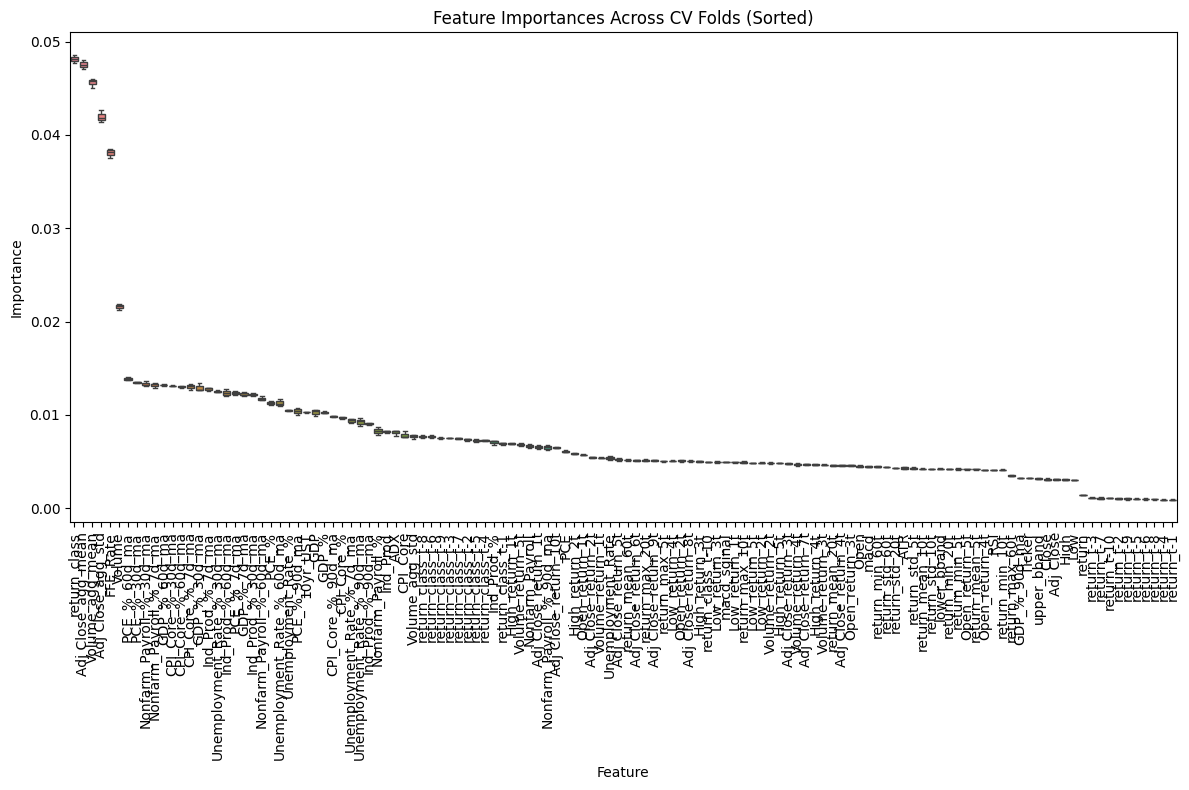

In [ ]:
# Sort the DataFrame by the mean importance
sorted_columns = mean_importances.index.tolist()
df_importances_sorted = df_importances[sorted_columns]

# Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_importances_sorted)
plt.xticks(rotation=90)
plt.title('Feature Importances Across CV Folds (Sorted)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

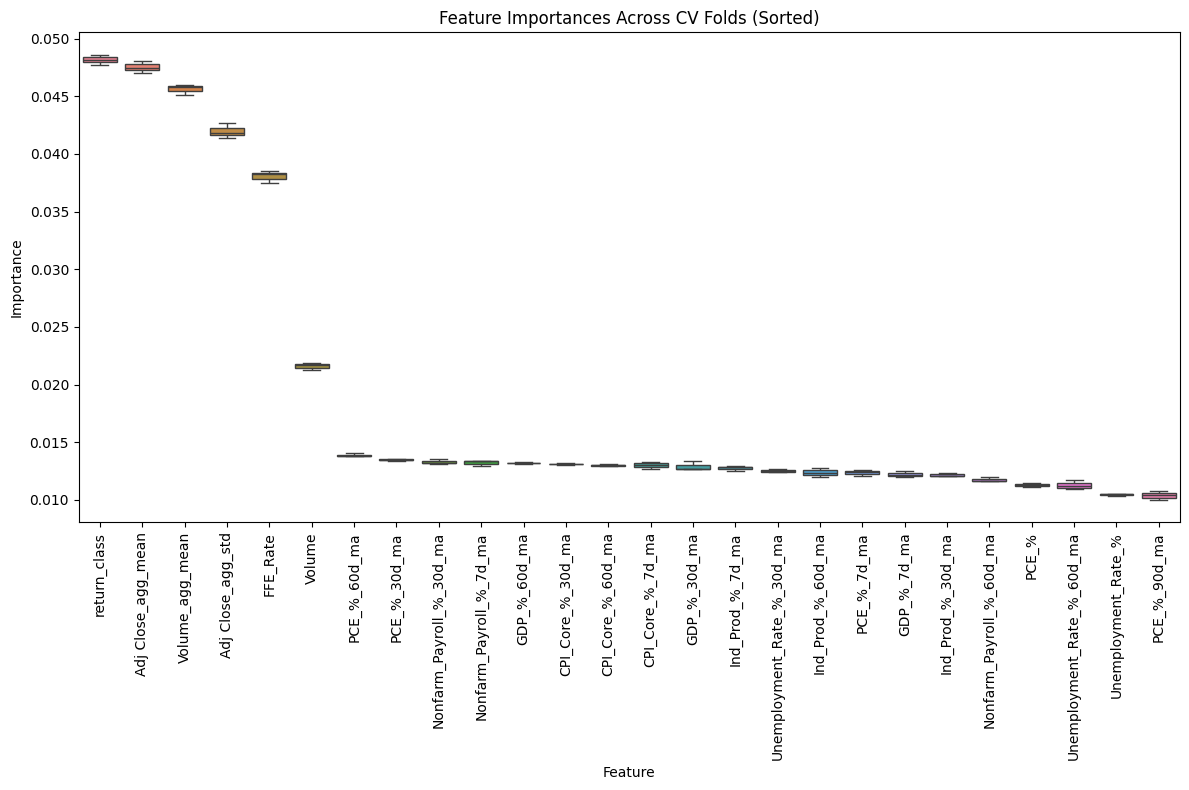

In [ ]:
# Convert the importances into a DataFrame for easier plotting
feature_names = X_train.columns.tolist()
df_importances = pd.DataFrame(all_importances, columns=feature_names)
df_importances = df_importances[top_features]
mean_importances = df_importances.mean().sort_values(ascending=False)

# Sort the DataFrame by the mean importance
sorted_columns = mean_importances.index.tolist()
df_importances_sorted = df_importances[sorted_columns]

# Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_importances_sorted)
plt.xticks(rotation=90)
plt.title('Feature Importances Across CV Folds (Sorted)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
#hard-cording top features with threshold = 0.5
top_features = ['return_class', 'Adj Close_agg_mean', 'Volume_agg_mean', 'Adj Close_agg_std', 'FFE_Rate', 'Volume', 'PCE_%_60d_ma', 'PCE_%_30d_ma', 'Nonfarm_Payroll_%_30d_ma', 'Nonfarm_Payroll_%_7d_ma', 'GDP_%_60d_ma', 'CPI_Core_%_30d_ma', 'CPI_Core_%_60d_ma', 'CPI_Core_%_7d_ma', 'GDP_%_30d_ma', 'Ind_Prod_%_7d_ma', 'Unemployment_Rate_%_30d_ma', 'Ind_Prod_%_60d_ma', 'PCE_%_7d_ma', 'GDP_%_7d_ma', 'Ind_Prod_%_30d_ma', 'Nonfarm_Payroll_%_60d_ma', 'PCE_%', 'Unemployment_Rate_%_60d_ma', 'Unemployment_Rate_%', 'PCE_%_90d_ma']

#replace main_df with selected features
main_df = main_df[['Ticker']+['y']+top_features]
main_df.shape

(2633373, 28)

# Train validation test split with updated main_df (reduced features)

In [ ]:
main_df = downcast(main_df)

<ipython-input-9-d1465e4f1bca>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[float64_cols] = df[float64_cols].astype('float32')


In [ ]:
# partition main df into train validation test sets
train_df = main_df[:end_train_date]
valid_df = main_df[end_train_date:end_valid_date]
train_valid_df = main_df[:end_valid_date]
test_df = main_df[end_valid_date:]

# split training data into X and y
X_train = train_df.drop('y', axis=1)
y_train = train_df['y']

# split validation data into X and y
X_valid = valid_df.drop('y', axis=1)
y_valid = valid_df['y']

# split training+validation data into X and y
X_train_valid = train_valid_df.drop('y', axis=1)
y_train_valid = train_valid_df['y']

# split test data into X and y
X_test = test_df.drop('y', axis=1)
y_test = test_df['y']

# RandomForest

## Refitting RandomForest with reduced main_df

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
#set best parameters based on the RandomSearchCV result
best_rf_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'max_samples': 0.7,
}

In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(**best_rf_params, random_state=42))
])


rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c49c816c280>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(dtype=<class 'numpy.float32'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c49c816dc00>)])),
                ('model',
                 RandomForestClassifier(max_depth=15, max_samples=0.7,
                                        random_state=42))])

In [ ]:
# Save the model to a file
rf_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/rf_model_w_reduced_data.joblib'
dump(rf_pipeline, rf_to_save)

print(f"Model saved to {rf_to_save}")

Model saved to /content/drive/My Drive/Colab Notebooks/Capstone/rf_model_w_reduced_data.joblib


## Evaluation

In [ ]:
rf_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/rf_model_w_reduced_data.joblib'
rf_pipeline = load(rf_load_from)

In [ ]:
y_scores = rf_pipeline.predict_proba(X_valid)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_scores)

In [ ]:
f1_scores = 2 * (precision * recall) / (precision + recall)

In [ ]:
# Ignore the last value of precision and recall because it corresponds to recall=0
max_f1_index = f1_scores[:-1].argmax()
max_f1 = f1_scores[max_f1_index]
best_threshold = thresholds[max_f1_index]

Highest F1: 0.6930230015395495 with Precision: 0.5302488126079448 with Recall: 1.0 at Threshold: 0.2574356411067113


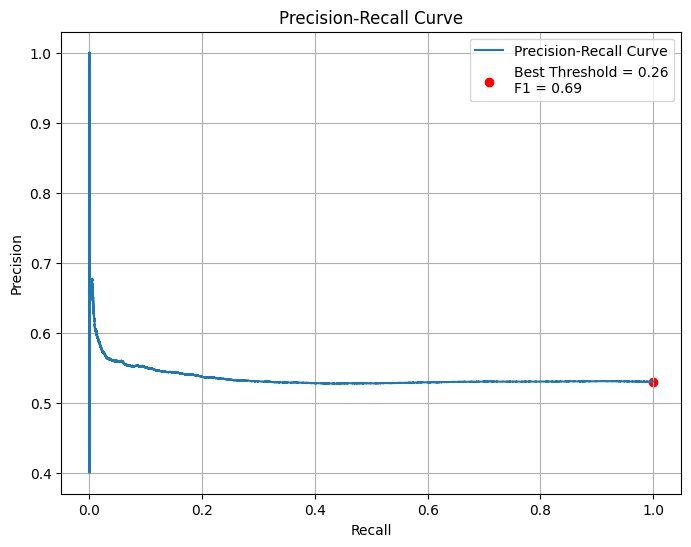

In [ ]:
print(f"Highest F1: {max_f1} with Precision: {precision[max_f1_index]} with Recall: {recall[max_f1_index]} at Threshold: {best_threshold}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[max_f1_index], precision[max_f1_index], marker='o', color='red', label=f'Best Threshold = {best_threshold:.2f}\nF1 = {max_f1:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# LightGBM

## Hyperparameter tuning with RandomSearchCV

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

In [ ]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42))
])

In [ ]:
#shorten data for RandomSearchCV to avoid crashing Google Colab
lgbm_start_date = '2013-01-01'
lgbm_train = train_df[lgbm_start_date:]
lgbm_X_train = lgbm_train.drop('y', axis=1)
lgbm_y_train = lgbm_train['y']

In [ ]:
lgbm_params = {
    'model__num_leaves': [31, 50, 70],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 200, 500],
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=252)

# Setup RandomizedSearchCV
lgbm_rs = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=lgbm_params,
    n_iter=20,
    scoring='precision',
    n_jobs=4,
    refit=True,
    cv=tscv,
    verbose=2,
    random_state=42,
)

lgbm_rs.fit(lgbm_X_train, lgbm_y_train)

# Save the model to a file
lgbm_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/best_lgbm_model.joblib'
dump(lgbm_rs.best_estimator_, lgbm_to_save)

print(f"Model saved to {lgbm_to_save}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 314149, number of negative: 281106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3002
[LightGBM] [Info] Number of data points in the train set: 595255, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527755 -> initscore=0.111136
[LightGBM] [Info] Start training from score 0.111136
Model saved to /content/drive/My Drive/Colab Notebooks/Capstone/rf_cv_result.joblib


In [ ]:
# Best parameters and score
best_params = lgbm_rs.best_params_
best_score = lgbm_rs.best_score_

print(f"Best parameters: {best_params}")
print(f"Best precision score: {best_score}")

Best parameters: {'model__num_leaves': 31, 'model__n_estimators': 100, 'model__learning_rate': 0.05}
Best precision score: 0.5126547884550973


## Light GBM Modeling

In [ ]:
lgbm_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/best_lgbm_model.joblib'
best_lgbm = load(lgbm_load_from)

In [ ]:
# Get the best hyperparameters from the best_rf model
best_parameters = best_lgbm.get_params()

print("Best Parameters:")
for parameter, value in best_parameters.items():
    print(f"{parameter}: {value}")

Best Parameters:
memory: None
steps: [('preprocessor', ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c23336d4df0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('ordinalencoder',
                                              

In [ ]:
#result from Grid Search
lgbm_best_params = {'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 31}

In [ ]:
#X_train = train_df.drop(columns=['Ticker','y'])
#y_train = train_df['y']
#X_valid = valid_df.drop(columns=['Ticker','y'])
#y_valid = valid_df['y']

lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(**lgbm_best_params, random_state=42))
])

lgbm_pipeline.fit(X_train, y_train)

# Save the model to a file
lgbm_to_save = '/content/drive/My Drive/Colab Notebooks/Capstone/best_lgbm_model_fitted.joblib'
dump(lgbm_pipeline, lgbm_to_save)

print(f"Model saved to {lgbm_to_save}")

[LightGBM] [Info] Number of positive: 966210, number of negative: 922397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.311963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6005
[LightGBM] [Info] Number of data points in the train set: 1888607, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511599 -> initscore=0.046405
[LightGBM] [Info] Start training from score 0.046405
Model saved to /content/drive/My Drive/Colab Notebooks/Capstone/best_lgbm_model_fitted.joblib


## Evalutation

In [ ]:
lgbm_load_from = '/content/drive/My Drive/Colab Notebooks/Capstone/best_lgbm_model_fitted.joblib'
lgbm_pipeline = load(lgbm_load_from)

In [ ]:
y_scores = lgbm_pipeline.predict_proba(X_valid)[:, 1]

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_scores)

Highest Precision: 0.532701158036689 with Recall: 0.6332720915674669 at Threshold: 0.45462816260008293


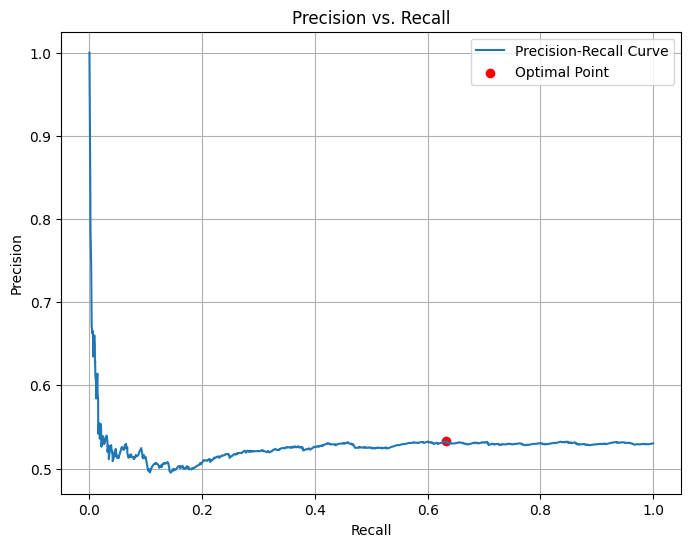

In [ ]:
filtered_indices = recall > 0.1
filtered_precision = precision[filtered_indices]
filtered_recall = recall[filtered_indices]
filtered_thresholds = thresholds[filtered_indices[:-1]]

max_precision_index = filtered_precision.argmax()
max_precision = filtered_precision[max_precision_index]
corresponding_recall = filtered_recall[max_precision_index]
corresponding_threshold = filtered_thresholds[max_precision_index]

print(f"Highest Precision: {max_precision} with Recall: {corresponding_recall} at Threshold: {corresponding_threshold}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(corresponding_recall, max_precision, color='red', label='Optimal Point')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall')
plt.legend()
plt.grid(True)
plt.show()

# Deep neural network

## Preprocessing pipeline

In [ ]:
# preprocessing for numerical variables
numerical_transformer = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler(),
)

# preprocessing for categorical variables
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent', add_indicator=True),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.float32),
)

# combine above two preprocessing steps into one pipeline step
preprocessor = make_column_transformer(
    (numerical_transformer, make_column_selector(dtype_exclude=object)),
    (categorical_transformer, make_column_selector(dtype_include=object)),
)

## Define neural network architecture

In [ ]:
class ReturnsClassifier(nn.Module):

    def __init__(
            self,
            num_units_1st=10,
            num_units_2nd=10,
            nonlin=F.relu,
            dropout=0.5,
    ):

        # initialise model
        super(ReturnsClassifier, self).__init__()
        self.num_units_1st = num_units_1st
        self.num_units_2nd = num_units_2nd
        self.nonlin = nonlin
        self.dropout = dropout

        # first hidden layer
        self.dense0 = nn.Linear((main_df.shape[1]-1), num_units_1st)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)

        # second hidden layer
        self.dense1 = nn.Linear(num_units_1st, num_units_2nd)
        self.output = nn.Linear(num_units_2nd, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

## Hyperparameter tuning

In [ ]:
# set random seeds for reproducability
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# define callbacks to monitor precision
prec = EpochScoring(scoring='precision', lower_is_better=False)

# instantiate skorch deep learning model
net = NeuralNetClassifier(
    module=ReturnsClassifier,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.SGD,
    train_split=None,
    iterator_train__shuffle=False,
    callbacks=[prec],
    verbose=0,
    device='cuda',  # uncomment to toggle between cpu/gpu
)

In [ ]:
dnn_gs.fit(X_train, y_train.astype(np.int64))

In [ ]:
# # save neural net weights, biases and hyperparams

# import pickle
# file_name = '/tmp/mymodel.pkl'

# with open(file_name, 'wb') as f:
#     pickle.dump(net, f)

# with open(file_name, 'rb') as f:
#     new_net = pickle.load(f)

# Ensemble models

In [ ]:
# collect classifier models into a list
estimators = [
    ("rf_clf", rf_pipeline),
    ("lgbm_clf", lgbm_pipeline),
    ("dnn_clf", dnn_model),
]

In [ ]:
# instantiate voting classifier ensemble model
voting_clf  = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=6,
)

In [ ]:
# instantiate stacking classifier ensemble model
stacking_clf  = StackingClassifier(
    estimators=estimators,
    cv=tscv,
    n_jobs=6,
)

# Model evaluation

In [ ]:
def show_precision_score(model, name, X, y):

    # compute mean cross-validated precision score
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        scoring='precision',
        cv=tscv,
        n_jobs=6,
    )

    # display mean and std of model
    print(f"""
        Cross-validated precision score of
        {name}
        - - -
        Mean: \t{scores.mean():.3f}
        Std dev: \t{scores.std():.3f}
    """)

In [ ]:
# instantiate a dummy classifier
dummy_clf = DummyClassifier(strategy='constant', constant=1)

In [ ]:
%%time

# cross validated mean precision score for dummy_clf
show_precision_score(dummy_clf, 'DUMMY CLASSIFIER', X_train_valid, y_train_valid)

In [ ]:
%%time

# cross validated mean precision score for dnn_model
show_precision_score(rf_pipeline, 'RANDOM FOREST CLASSIFIER', X_train_valid, y_train_valid)

In [ ]:
%%time

# cross validated mean precision score for dnn_model
show_precision_score(lgbm_pipeline, 'LIGHTGBM CLASSIFIER', X_train_valid, y_train_valid)

In [ ]:
%%time

# cross validated mean precision score for dnn_model
show_precision_score(dnn_model, 'DEEP NEURAL NETWORK CLASSIFIER', X_train_valid, y_train_valid)

In [ ]:
%%time

# cross validated mean precision score for voting_clf
show_precision_score(voting_clf, 'VOTING CLASSIFIER ENSEMBLE', X_train_valid, y_train_valid)

In [ ]:
%%time

# cross validated mean precision score for stacking_clf
show_precision_score(stacking_clf, 'STACKING CLASSIFIER ENSEMBLE', X_train_valid, y_train_valid)

# Trading Performance

In [ ]:
perf_df['buy'] == #buy signal test set result here

# Calculate daily average return for the base case
perf_df['daily_return'] = df['Adj Close_return_1t'] / 365
base_case_daily_avg = df.groupby(df.index)['daily_return'].mean()

# Calculate daily average return for the model case
model_case_daily_avg = df[df['buy'] == 1].groupby(df.index)['daily_return'].mean()

# Cumulative returns are calculated as the simple sum of daily averages
base_case_cumulative = base_case_daily_avg.cumsum()
model_case_cumulative = model_case_daily_avg.cumsum()

# Create a DataFrame for plotting
cumulative_returns_df = pd.DataFrame({
    'Base Case Cumulative Return': base_case_cumulative,
    'Model Case Cumulative Return': model_case_cumulative
})

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_df.index, cumulative_returns_df['Base Case Cumulative Return'], label='Base Case', color='blue')
plt.plot(cumulative_returns_df.index, cumulative_returns_df['Model Case Cumulative Return'], label='Model Case', color='green')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#sharpe ratio
base_return = (cumulative_returns_df['Base Case Cumulative Return'][-1:] - cumulative_returns_df['Base Case Cumulative Return'][0])**(1/3)-1
model_return = (cumulative_returns_df['Model Case Cumulative Return'][-1:] - cumulative_returns_df['Model Case Cumulative Return'][0])**(1/3)-1
rf_rate = 0.168 #3yr treasury yield on 2021-01-03
std = np.std(base_case_daily_avg)
std *= np.sqrt(250) #daily std annualized

base_sharpe = (base_return - rf_rate) / std
model_sharpe = (model_return - rf_rate) / std

print(f'Base case sharpe ratio: {base_sharpe}')
print(f'Model case sharpe ratio: {model_sharpe}')

# END

In [ ]:
# dependencies
%load_ext watermark
%watermark --python --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

seaborn   : 0.13.1
requests  : 2.31.0
pandas    : 1.5.3
yfinance  : 0.2.37
lightgbm  : 4.1.0
torch     : 2.2.1+cu121
talib     : 0.4.28
numpy     : 1.25.2
matplotlib: 3.7.1
fredapi   : 0.5.1



Dependencies as of 01 March 2024:

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas    : 1.5.3
matplotlib: 3.7.1
requests  : 2.31.0
yfinance  : 0.2.37
numpy     : 1.25.2
fredapi   : 0.5.1